This notebook evaluates the XEC reaction bromide scope after pruning samples containing poorly performing functional groups.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Code.benchmark import Benchmark
from Code.predictor import ScopeBO
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist
from umap import UMAP
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys


# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14, # Legend titles
    "font.family": "Helvetica"   # Font
})

### Collecting data for BO-based methods

In order to calculate scope scores for this dataset, we first established objective bounds for the normalization of them using the workflow established in the hyperparameter optimization for the ArI oxidative addtion dataset.

NOTE: Batch size two was excluded from greedy bounds runs because it led to numerical problems of the GP surrogate model.

In [2]:
# # Low vendi and high objective bounds with the greedy acquisition function without pruning
# Benchmark().collect_data(
#     filename_labelled = "./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
#     name_results = "./Results_Data/results_pruned/bounds/greedy40",
#     objectives=['yield'],
#     budget = 40,
#     batches= [1,2,3,4],
#     Vendi_pruning_fractions = [0],
#     seeds = 40,
#     acquisition_function_mode= "greedy",
#     init_sampling_method="random")

In [3]:
# # High vendi and low objective bounds with the explorative acquisition function with max pruning for the respective batch size
# run_settings = {1: 5, 2: 13, 3: 20, 4: 26}
# for batch_size in run_settings.keys():
#     Benchmark().collect_data(
#             filename_labelled = "./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
#         name_results = f"./Results_Data/results_pruned/bounds/explorative40_b{batch_size}",
#         objectives=['yield'],
#         budget = 40,
#         batches= [batch_size],
#         Vendi_pruning_fractions = [run_settings[batch_size]],
#         seeds = 40,
#         acquisition_function_mode= "explorative",
#         pruning_metric= "vendi_batch",
#         init_sampling_method="random")

In [4]:
# Use the results of the greedy acqusition function (no pruning) with scope size 40, to get the upper bounds for the yield and the lower bounds for 
# the vendi score.
dfs_bounds_greedy = {}
for metric in ["yield","vendi"]:
    dfs_bounds_greedy[metric] = Benchmark().heatmap_plot(type_results=metric,
                                                         name_results="./Results_Data/results_pruned"\
                                                            "/bounds/greedy40",budget=40,show_plot=False)
bounds_greedy = pd.concat(dfs_bounds_greedy,axis=1)
bounds_greedy.columns = ["yield","vendi"]
yield_max = bounds_greedy["yield"].max()
vendi_min = bounds_greedy["vendi"].min()
print(f"upper bounds yield: {yield_max}")
print(f"lower bounds vendi score: {vendi_min}")

upper bounds yield: 33.042375
lower bounds vendi score: 1.9440196723872827


In [5]:
# Use the results of the explorative acqusition function (max pruning) with scope size 40, to get the lower bounds for the yield and the upper bounds for 
# the vendi score.
dfs_bounds_explorative = {}
objective_mode = "max"
for metric in ["yield","vendi"]:
    dfs_metric = {}
    for batch_size in [1,2,3,4]:
        dfs_metric[batch_size] = Benchmark().heatmap_plot(type_results=metric,
                                                          name_results=f"./Results_Data/results_pruned/"\
                                                            f"bounds/explorative40_b{batch_size}",budget=40,show_plot=False)
    explorative_values = pd.concat(dfs_metric,axis=1)
    explorative_values.columns = [1,2,3,4]
    explorative_values = explorative_values.stack().reset_index(drop=True)
    dfs_bounds_explorative[metric] = pd.DataFrame({metric: explorative_values})
bounds_explorative = pd.concat(dfs_bounds_explorative,axis=1)
bounds_explorative.columns = ["yield","vendi"]
yield_min = bounds_explorative["yield"].min()
vendi_max = bounds_explorative["vendi"].max()
print(f"lower bounds yield: {yield_min}")
print(f"upper bounds vendi score: {vendi_max}")

lower bounds yield: 15.071562500000002
upper bounds vendi score: 4.728115071745245


In [6]:
# Record the bounds
yield_bounds = (yield_max,yield_min)
vendi_bounds = (vendi_max,vendi_min)
bounds = {"yield": yield_bounds, "vendi": vendi_bounds}

After having established the bounds for the objectives, we can run the scopes with different acquisition functions using the optimized conditions and also without Vendi pruning.

In [7]:
# for acq in ["ei","random-selection","greedy","explorative"]:
#     if acq == "ei":
#         acq_label = "balanced"
#     elif acq == "random-selection":
#         acq_label = "random"
#     else:
#         acq_label = acq
#     for pruning in [False,True]:
#         if pruning:
#             pruning_label = "with-pruning"
#             pruning_fraction = 13
#         else:
#             pruning_label = "no-pruning"
#             pruning_fraction = 0
#         Benchmark().collect_data(
#             filename_labelled = f"./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
#             name_results = f"./Results_Data/results_pruned/scope_{acq}_{pruning_label}",
#             objectives=['yield'],
#             budget = 27,
#             batches= [3],
#             Vendi_pruning_fractions = [pruning_fraction],
#             seeds = 40,
#             acquisition_function_mode= acq_label,
#             pruning_metric= "vendi_batch",
#             init_sampling_method="random")

In [8]:
# # simulate scopes similar to how humans conventionally select scopes
# Benchmark().collect_data(
#     filename_labelled = f"./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
#     name_results = f"./Results_Data/results_pruned/scope_human-like-acq",
#     objectives=['yield'],
#     budget = 27,
#     batches= [3],
#     Vendi_pruning_fractions = [5],
#     seeds = 40,
#     acquisition_function_mode= "greedy",
#     pruning_metric= "vendi_batch",
#     init_sampling_method="random")

Plot the results

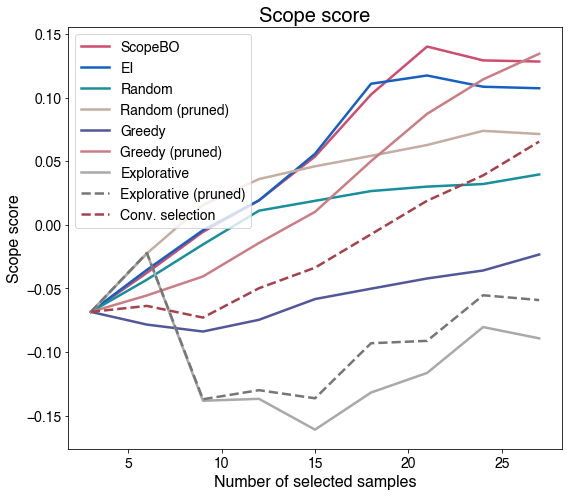

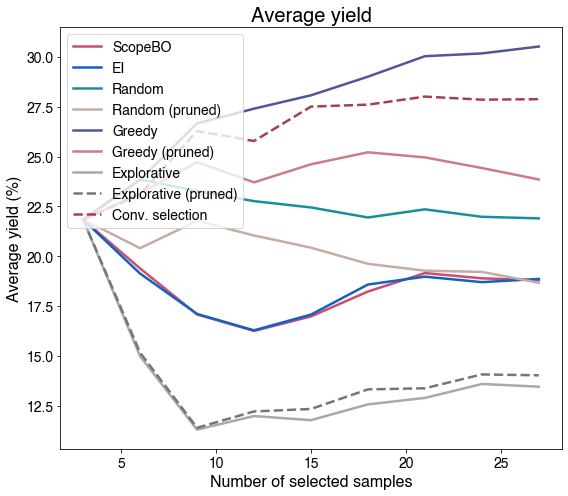

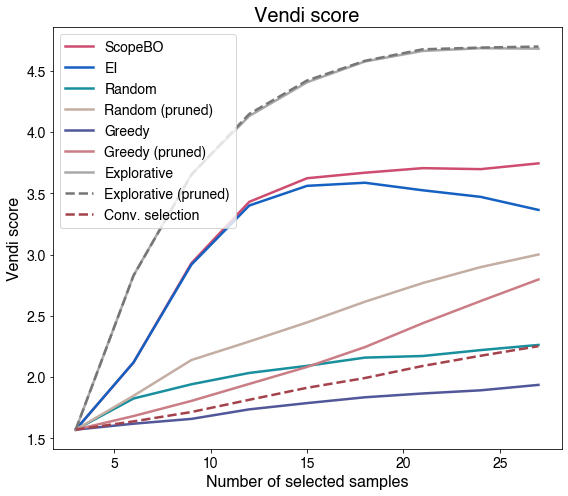

In [9]:
def score_overview(metrics):
    for type_results in metrics:
        # Initialize the figure
        plt.figure(figsize=(8,7))
        dfs = {}
        for acq in ["EI","Random","Greedy","Explorative","Conv. selection"]:
            if acq.lower() == "random":
                acq_label = "random-selection"
            elif acq == "Conv. selection":
                acq_label = "human-like-acq"
            else:
                acq_label = acq.lower()
            for pruning in [False,True]:
                if pruning:
                    pruning_label = "_with-pruning"
                else:
                    pruning_label = "_no-pruning"
                if acq == "Conv. selection":
                    pruning_label = ""
                dfs_progress = Benchmark().progress_plot(budget=27, type_results= type_results,
                                        name_results=f"./Results_Data/results_pruned/scope_{acq_label}{pruning_label}",
                                        bounds={"yield":yield_bounds,"vendi":vendi_bounds},show_plot=False)
                dfs[acq+pruning_label] = dfs_progress["means"]
        df_combined = pd.concat(dfs,axis=1)
        df_combined.columns = [multiindex[0] for multiindex in df_combined.columns]
        df_combined.rename(columns={"EI_with-pruning":"ScopeBO"},inplace=True)
        df_combined = df_combined[["ScopeBO"] + [col for col in df_combined.columns if col != "ScopeBO"]]
        label_dict = {col: col for col in df_combined.columns}
        for key,val in label_dict.items():
            if "_no-pruning" in val:
                label_dict[key] = val.split("_")[0]
            elif "with-pruning" in val:
                label_dict[key] = val.split("_")[0] + " (pruned)"
        df_combined.rename(columns=label_dict,inplace=True)
        for j,col in enumerate(df_combined.columns):
            style = '-' if j <= 6 else '--' if j <= 13 else ':'
            plotting = df_combined[col][df_combined[col].notna()]
            plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)
        plt.xlabel('Number of selected samples',fontsize=16)
        plt.ylabel(f"{type_results} score",fontsize=16)
        if type_results == "Objective":
            plt.title("Average yield",fontsize=20)
            plt.ylabel(f"Average yield (%)",fontsize=16)
        else:
            plt.title(f"{type_results} score",fontsize=20)
            plt.ylabel(f"{type_results} score",fontsize=16)
        plt.legend(fontsize=14,loc = "upper left")
        plt.tight_layout()
        plt.show()

score_overview(["Scope"])
score_overview(["Objective","Vendi"])

ScopeBo essentially has the same performance as the top-performer (greedy acquisition function with Vendi pruning) while providing a stronger emphasis on diversity as evidenced by the higher Vendi score.

### Evaluation of a scope initiation strategy based on selecting high performers in the initial round

We can now evaluate the scope initiation strategy of selecting high-performing samples in the first round. This strategy was established with the ArI dataset.

In [11]:
# get the data for the different random initiations

# get the data for the inidividual seeds
_, dict_raw_data = Benchmark.get_metric_overview(bounds=bounds,budget=27,type_results="scope", 
                            name_results=f"./Results_Data/results_pruned/scope_ei_with-pruning")
# dfs_raw_data[dset] contains a dict for all batch-pruning combination with another dict as 
# the value which contains the data for the random seeds
# here, we only have one combination (b3_V13 --> optimized hyperparameters)
# --> reassign dfs_raw_data for simplier handling
dfs_raw_data = dict_raw_data["b3_V13"]

In [12]:
print("Data for the first initiation as an example:")
dfs_raw_data[0]

Data for the first initiation as an example:


vendi      yield     scope
0  1.474528  43.700000 -0.268642
1  1.890125  30.333333 -0.016440
2  3.002164  20.222222  0.108932
3  3.556117  16.741667  0.053812
4  3.872337  15.006667 -0.002501
5  3.835416  13.072222 -0.075582
6  3.703269  17.085714  0.070822
7  3.626055  18.666667  0.120863
8  3.584315  20.888889  0.190719

Distribution of all scopes scores across the random seeds:


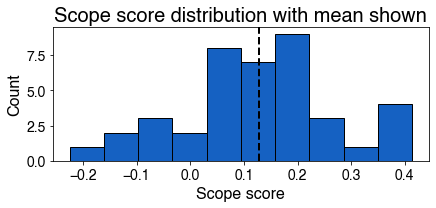

In [13]:
# get and plot the final scope scores for the inidividual seeds
nr_seeds = len(dfs_raw_data)
score_list = [dfs_raw_data[i].loc[8,"scope"] for i in range(nr_seeds)]
mean_score = np.mean(score_list)  # mean scope score
print("Distribution of all scopes scores across the random seeds:")
plt.figure(figsize=(6,3))
plt.title("Scope score distribution with mean shown")
plt.xlabel("Scope score")
plt.hist(score_list, color=all_colors[1], bins=10, edgecolor="k")
plt.axvline(x=mean_score, color='black', linestyle='--', linewidth=2)
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [14]:
# get lists for the metrics of the initial samples
initial_vendi = {}
initial_obj = {}

# check: How are the final scope scores when the initiations with the highest initial average rates are regarded?
summ_top_yields = pd.DataFrame(np.nan,index=["Top5 initial av. yield", "random initiation"],
                             columns=["Mean final scope score",
                                      "Worst final scope score",
                                      "Mean initial average yield"])

In [15]:
initial_vendi = [dfs_raw_data[i].loc[0,"vendi"] for i in range(nr_seeds)]
initial_obj = [dfs_raw_data[i].loc[0,"yield"] for i in range(nr_seeds)]

summ_top_yields.loc["random initiation","Mean initial average yield"] = round(np.mean(initial_obj),3)
summ_top_yields.loc["random initiation","Mean final scope score"] = round(np.mean(np.array(score_list)),3)
summ_top_yields.loc["random initiation","Worst final scope score"] = round(np.min(np.array(score_list)),3)


# get the seeds that have the top 5 initial average rates
indexed_rates = list(enumerate(initial_obj))  # generate (index,av. yield) tuples
top_5 = sorted(indexed_rates, key=lambda x: x[1], reverse=True)[:5]  # sort by score
best_seeds = [index for index, yield_val in top_5]
print(f"Top 5 seeds by initial average yield:", best_seeds)

# get the averages of the final samples for the top 5 seeds
best_init_final_scope = [dfs_raw_data[i].loc[8,"scope"] for i in best_seeds]
best_init_yield = [initial_obj[i] for i in best_seeds]

summ_top_yields.loc["Top5 initial av. yield","Mean final scope score"] = round(np.mean(best_init_final_scope),3)
summ_top_yields.loc["Top5 initial av. yield","Worst final scope score"] = round(np.min(best_init_final_scope),3)
summ_top_yields.loc["Top5 initial av. yield","Mean initial average yield"] = round(np.mean(best_init_yield),3)

summ_top_yields

Top 5 seeds by initial average yield: [34, 0, 8, 15, 27]


Mean final scope score  Worst final scope score  \
Top5 initial av. yield                   0.163                    0.061   
random initiation                        0.128                   -0.225   

                        Mean initial average yield  
Top5 initial av. yield                      42.460  
random initiation                           21.838

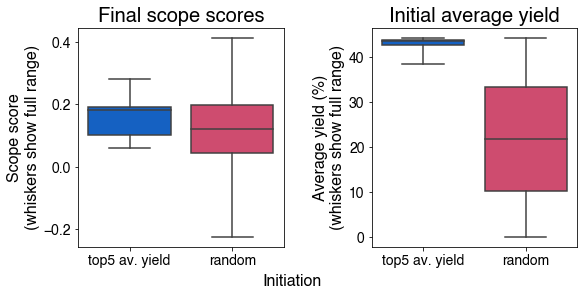

In [16]:
fig, axes = plt.subplots(1,2, figsize = (8,4),gridspec_kw={"wspace": 0.1},constrained_layout=True)
for i, results_type in enumerate(["scope","yield"]):
    ax = axes[i]
    if results_type == "scope":
        ax.set_title("Final scope scores")
    else:
        ax.set_title("Initial average yield")
    fig.supxlabel("Initiation",fontsize=16)
    if results_type == "scope":
        df = pd.DataFrame([best_init_final_scope,score_list])
    else:
        df = pd.DataFrame([best_init_yield,initial_obj])
    df_long = df.T.melt(var_name='Row', value_name='Value')
    df_long.loc[df_long["Row"] == 0,"Row"] = "top5 av. yield"
    df_long.loc[df_long["Row"] == 1,"Row"] = "random"
    palette = [all_colors[1], all_colors[0]]
    sns.boxplot(ax=ax,x='Row', y='Value', data=df_long, whis=[0,100], palette=palette, saturation=1)
    if results_type == "scope":
        ax.set_ylabel('Scope score\n(whiskers show full range)')
    elif results_type == "yield":
        ax.set_ylabel("Average yield (%)\n(whiskers show full range)")
    ax.set_xlabel("")
plt.show()

Initiating the scope with high performing samples increases both the mean and worst-case scope score at the end of the scope, validating the analoguous studies with the ArI dataset.

### Clustering using the approach by Doyle

In [17]:
# Read in the labelled dataset and scale it
df_labelled = pd.read_csv("./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv", index_col=0,header=0)
df_data = df_labelled.copy(deep=True)
df_data = df_data.drop(columns=['yield'])  # drop the objective values
df_data = pd.DataFrame(scale(df_data),df_data.index,df_data.columns)
objectives = ["yield"]
wdir = Path(".")

# Make a UMAP for the visualization of the results
fit = UMAP(n_neighbors=40,min_dist=0.7,n_components=2,metric="euclidean",random_state=12)
df_umap = pd.DataFrame(fit.fit_transform(df_data),df_data.index,["UMAP1","UMAP2"])
df_umap.to_csv("./../XEC_data/Datasets/xec_dft_umap_bromide_scope_pruned.csv")

print(f"There are {len(df_data.columns)} dimensions in the dataset.")


There are 33 dimensions in the dataset.


In [18]:
# define the dimensionalities of the reduced representation to study
dims = [33, 30, 25, 20, 15, 10, 5, 2]

# function to calculate silhouette scores
def silhouette_scores_hierarchical(data, n_cls_list):
    """helper function to compute a silhouette score for hierarchical clustering using Ward linkage"""
    z = linkage(data, method='ward')
    result = pd.Series(index=n_cls_list, dtype=float)
    for n_cls in n_cls_list:
        cls = fcluster(z, n_cls, criterion='maxclust')
        result.loc[n_cls] = silhouette_score(data, cls)
    return result

# dictionary to store data at different levels of dimensionality reduction
n_neighbors = int(np.sqrt(df_data.shape[1]))
dfs = {}
for dim in dims:
    key = f"umap{dim}"
    dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=n_neighbors,
                                    random_state=0).fit_transform(df_data),index=df_data.index)

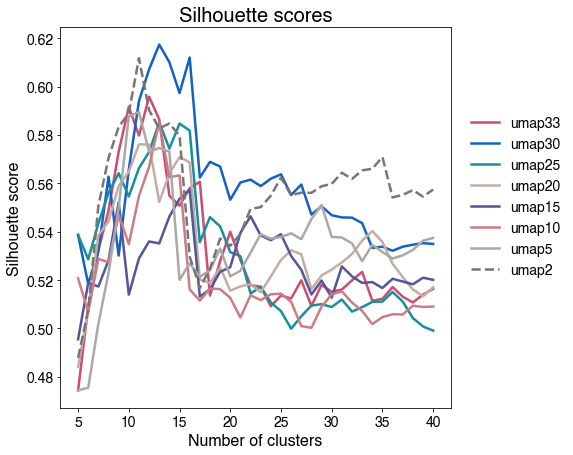

Representation  Nr_clusters  Silh_score  \
Results         umap30         13.0    0.617363   

        Representation (min 15 clusters)  Nr_clusters (min 15 clusters)  \
Results                           umap30                           16.0   

         Silh_score (min 15 clusters)  
Results                      0.612011

In [19]:
# range of scope sizes to be studied
N_CLS_list = list(range(5,41))
# min number of clusters for the scope
min_clust = 15
# df to save the results of the silhouette score analysis
best_silh_scores = pd.DataFrame(np.nan,index=["Results"],columns=["Representation","Nr_clusters", "Silh_score",
                                                               f"Representation (min {min_clust} clusters)", 
                                                               f"Nr_clusters (min {min_clust} clusters)",
                                                               f"Silh_score (min {min_clust} clusters)"])

plt.figure(figsize=(7,7))
plt.title("Silhouette scores")
plt.xlabel("Number of clusters",fontsize=16)
plt.ylabel("Silhouette score",fontsize=16)

# populate silhouette scores for all number of clusters and all dimensionality reductions
silh_scores = pd.DataFrame(index=N_CLS_list)
for key, value in dfs.items():
    silh_scores[key] = silhouette_scores_hierarchical(value, N_CLS_list)
for j,col in enumerate(silh_scores.columns):
    style = '-' if j <= 6 else '--' if j <= 13 else ':'
    plotting = silh_scores[col][silh_scores[col].notna()]
    plt.plot(plotting.index, plotting.values, label = col, color=all_colors[j], linestyle=style, linewidth=2.5)

# record the representation that gives the best silhouette score
max_position = silh_scores.stack().idxmax()
best_silh_scores.loc["Results","Representation"] = max_position[1]
best_silh_scores.loc["Results","Nr_clusters"] = int(max_position[0])
best_silh_scores.loc["Results","Silh_score"] = silh_scores.max().max()
silh_scores_pruned = silh_scores.loc[silh_scores.index >= min_clust]
max_position_pruned = silh_scores_pruned.stack().idxmax()
best_silh_scores.loc["Results",f"Representation (min {min_clust} clusters)"] = max_position_pruned[1]
best_silh_scores.loc["Results",f"Nr_clusters (min {min_clust} clusters)"] = int(max_position_pruned[0])
best_silh_scores.loc["Results",f"Silh_score (min {min_clust} clusters)"] = silh_scores_pruned.max().max()
plt.legend(loc='center left',
           frameon =False,
           bbox_to_anchor=(1.02, 0.555))
plt.show()

best_silh_scores

In [20]:
embedding = best_silh_scores.loc["Results",f"Representation (min {min_clust} clusters)"]
nr_clusters = best_silh_scores.loc["Results",f"Nr_clusters (min {min_clust} clusters)"]

# Clustering
z = hierarchy.linkage(dfs[embedding],method ="ward",metric="euclidean")
clusters = hierarchy.fcluster(z,nr_clusters,criterion="maxclust")

# Assign to samples
df_data["clusters"] = clusters
df_umap["clusters"] = clusters

Visualization of the clusters:


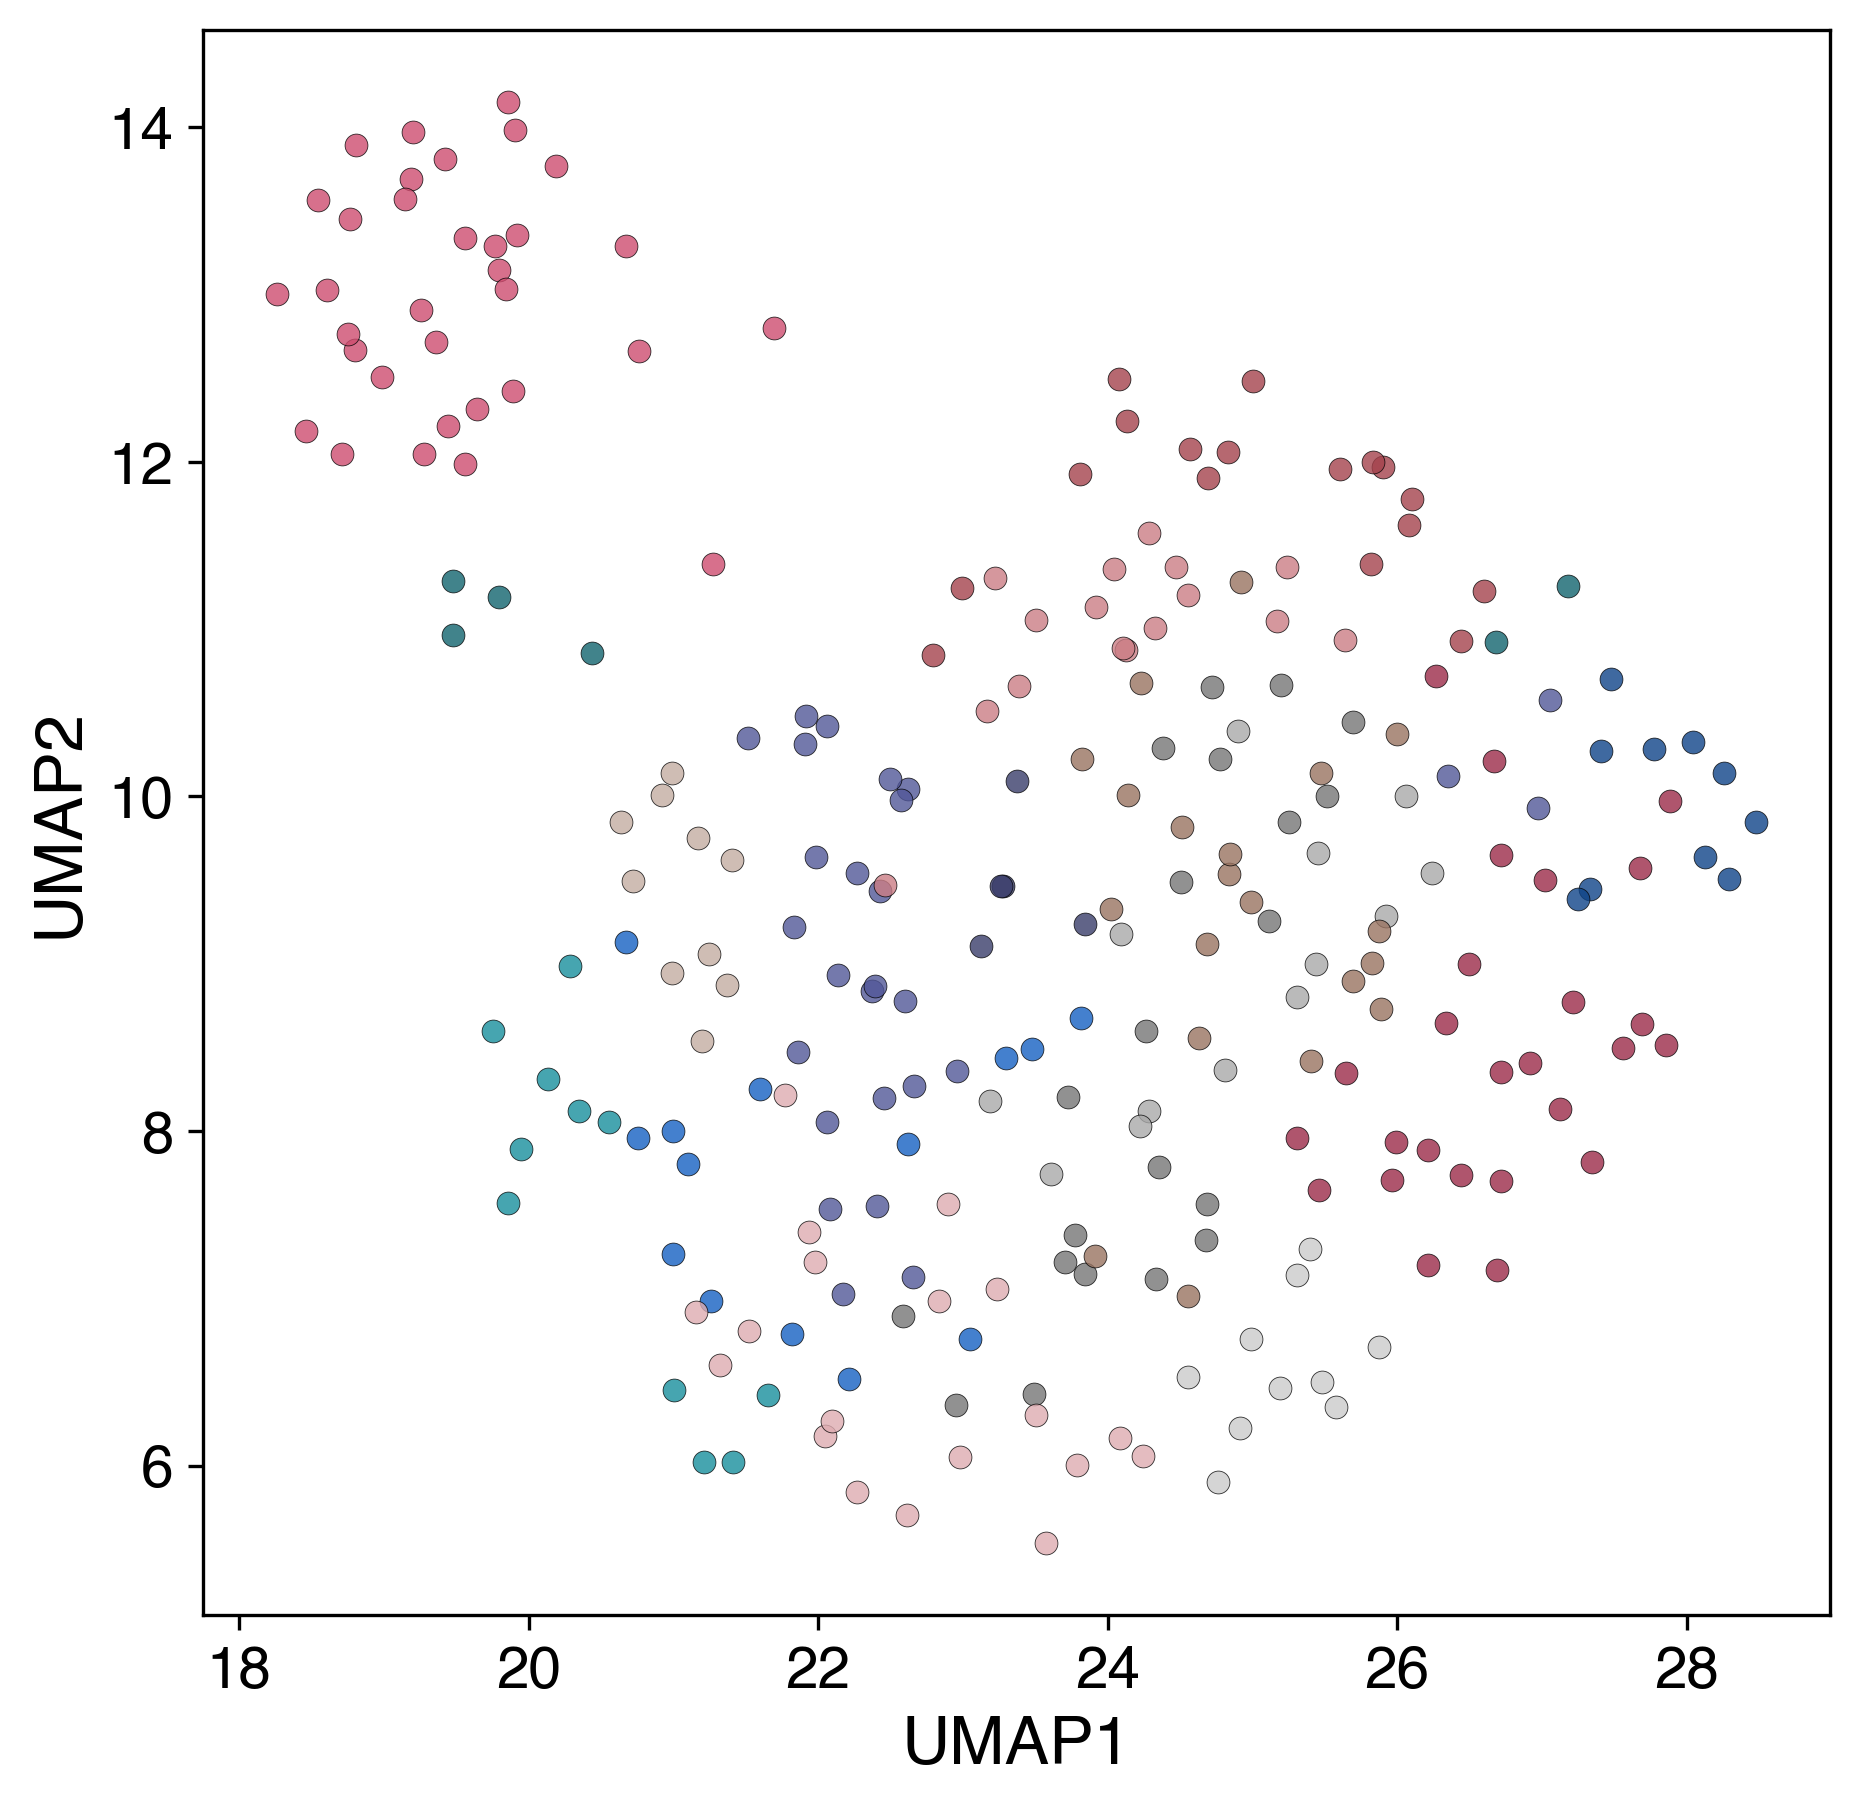

Please note that some colors only differ in the shade.


In [21]:
# draw the clusters
print("Visualization of the clusters:")

# making sure there are enough colors
all_colors = all_colors * 4

plt.figure(figsize=(7,7),dpi=300)
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

for cluster_id in sorted(df_umap['clusters'].unique()):
    color_id = cluster_id-1  # colors are zero-index, but clusters one-indexed
    cluster_data = df_umap[df_umap['clusters'] == cluster_id]
    plt.scatter(
        cluster_data['UMAP1'], cluster_data['UMAP2'],
        color=all_colors[color_id],
        label=f'Cluster {cluster_id}',
        s=30, alpha=0.8, edgecolor='k', linewidth=0.2
    )
plt.show()
print("Please note that some colors only differ in the shade.")

In [22]:
# function to calculate the scope score
def calculate_scope_score(av_yield,Vendi_score,bounds):
    scaled_yield = (av_yield - bounds["yield"][1])/(bounds["yield"][0] - bounds["yield"][1])
    scaled_Vendi = (Vendi_score - bounds["vendi"][1])/(bounds["vendi"][0] - bounds["vendi"][1])

    return scaled_yield * scaled_Vendi

In [23]:
# calculate the center-most point of each cluster and the Vendi score for the resulting samples
scope_results = pd.DataFrame(np.nan,index=["Results"],columns=["Average yield (%)","Vendi score","Scope score"])

cluster_yields = [] # list to save the yields
df_vendi = df_labelled.copy(deep=True)
df_vendi["yield"] = "PENDING"  # reset the yield data so that only the selected points will have a yield
for cluster in range(max(df_data["clusters"].unique())):  # loop through all clusters
    cluster = cluster+1  # +1 because the range object is 0-indexed whereas the cluster are 1-indexed
    df_cluster = df_data.loc[df_data["clusters"]== cluster]  # look at the points in the current cluster
    df_cluster = df_cluster.drop(columns=["clusters"])  # drop the cluster column to only keep the features (df_data did not contain the yield data)
    centroid = df_cluster.mean().values  # this is the center of the cluster
    distances = cdist(df_cluster,[centroid],metric="cityblock").flatten()  # calculate the distances to the center
    df_cluster["distances"] = distances
    centermost_point = df_cluster[df_cluster["distances"] == df_cluster["distances"].min()].index.item()  # get the center-most point
    yield_clusterpoint = df_labelled.at[centermost_point,"yield"]  # get the yield data for the center-most point
    df_vendi.loc[centermost_point,"yield"] = "1"  # put a label for the vendi score calculation (value is not important)
    cluster_yields.append(yield_clusterpoint)  # save the point
av_yield = sum(cluster_yields)/len(cluster_yields)
scope_results.loc["Results","Average yield (%)"] = av_yield
df_vendi.to_csv(wdir.joinpath("df_data_vendi.csv"),index=True,header=True)  # save the file (as the Vendi score calculation needs a file as input)
Vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],directory=".",filename="df_data_vendi.csv")  # calculate the vendi score
scope_results.loc["Results","Vendi score"] = Vendi_score
scope_score = calculate_scope_score(av_yield,Vendi_score,bounds)
scope_results.loc["Results","Scope score"] = scope_score

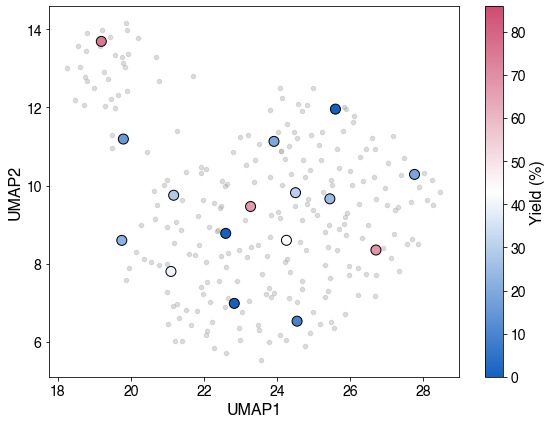

Scope results:


Average yield (%)  Vendi score  Scope score
Results              28.85     2.050944     0.029446

In [24]:
plt.figure(figsize=(8,6))
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

# only keep the objective label for evaluated points
df_umap["yield"] = df_labelled["yield"]

for idx in df_vendi.index:
    if df_vendi.loc[idx,"yield"] == "PENDING":
        df_umap.loc[idx,"yield"] = "PENDING"

# Separate numeric and non-numeric (e.g., "PENDING") entries
df_numeric = df_umap[pd.to_numeric(df_umap['yield'], errors='coerce').notna()].copy()
df_numeric['yield'] = df_numeric['yield'].astype(float)
df_pending = df_umap[pd.to_numeric(df_umap['yield'], errors='coerce').isna()]

# Define colormap and normalization
vmin = df_labelled['yield'].min()
vmax = df_labelled['yield'].max()
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("Doyle_cont", as_cmap=True)

# Plot non-numeric entries ("PENDING")
plt.scatter(df_pending["UMAP1"], df_pending["UMAP2"], color=all_colors[6], s=20, alpha=0.4, label="PENDING")
# Plot numeric entries
scatter_numeric = plt.scatter(df_numeric["UMAP1"],df_numeric["UMAP2"],c=df_numeric["yield"],cmap=cmap,norm=norm,s=100,alpha=1,edgecolor='k',linewidth=1)
# Add colorbar
cbar = plt.colorbar(scatter_numeric)
cbar.set_label("Yield (%)")

plt.tight_layout()
plt.show()
print("Scope results:")
scope_results

The average yield is high, but the Vendi score is very low due to the low number of samples.

In [25]:
# function to show the molecular structure of the selected compounds
def generate_representation(smiles_list,common_core="C(=O)O"):
    # Convert to molecules
    mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Generate 2D coordinates for all mols
    for mol in mol_list:
        AllChem.Compute2DCoords(mol)

    # Define common core substructure for alignment
    core = Chem.MolFromSmarts(common_core)
    AllChem.Compute2DCoords(core)

    # Align each molecule to the substructure if it matches
    for mol in mol_list:
        if mol.HasSubstructMatch(core):
            AllChem.GenerateDepictionMatching2DStructure(mol, core)

    return mol_list

Selected scope:


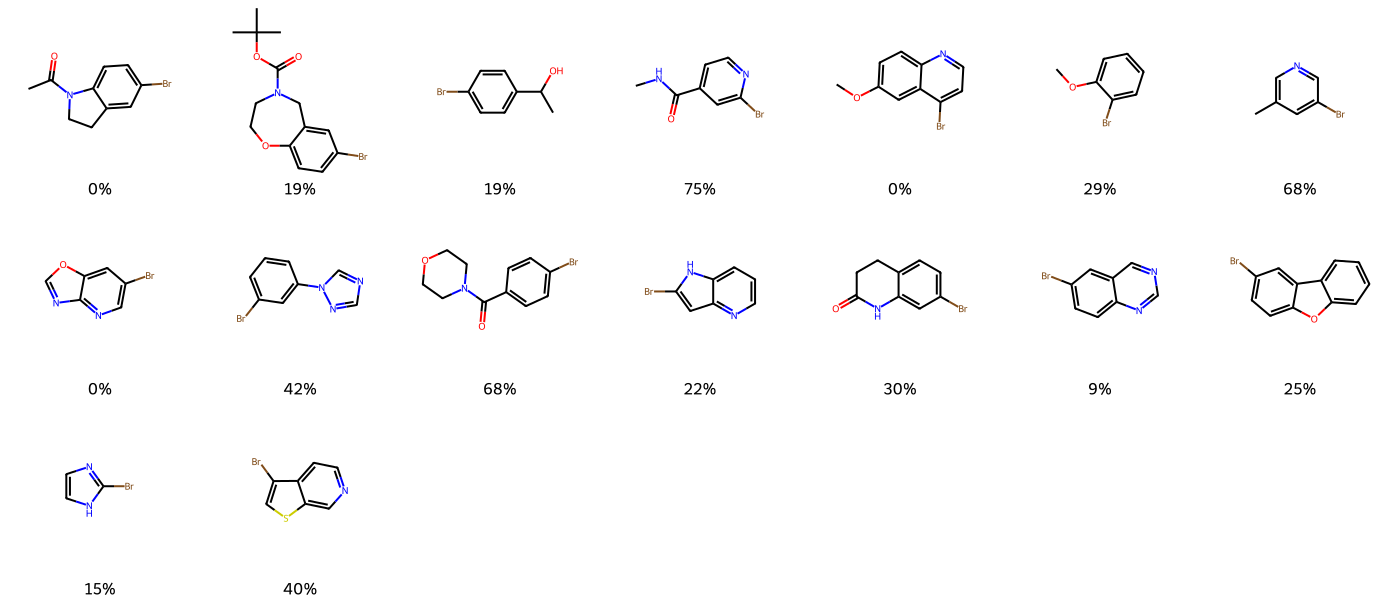

In [26]:
print("Selected scope:")
df_selected = df_umap.loc[df_umap["yield"] != "PENDING"]
mol_list = generate_representation(list(df_selected.loc[df_selected["yield"] != "PENDING"].index))
depiction = Draw.MolsToGridImage(
    mol_list,
    molsPerRow=7,
    subImgSize=(200, 200),
    legends=[f"{round(df_selected.loc[smiles,'yield'])}%" for smiles in df_selected.index]
    )
display(depiction)

Redo the scope selection with a fixed scope size of 27 samples (same as ScopeBO)

In [27]:
print("Best representation and silhouette score for a scope size of 27:"\
      f" {silh_scores.loc[27].idxmax()}; {silh_scores.loc[27].max()}")
embedding = silh_scores.loc[27].idxmax()
nr_clusters = 27
# Clustering
z = hierarchy.linkage(dfs[embedding],method ="ward",metric="euclidean")
clusters = hierarchy.fcluster(z,nr_clusters,criterion="maxclust")

# Assign to samples
df_data["clusters"] = clusters
df_umap["clusters"] = clusters

Best representation and silhouette score for a scope size of 27: umap30; 0.5594935417175293


Visualization of the clusters:


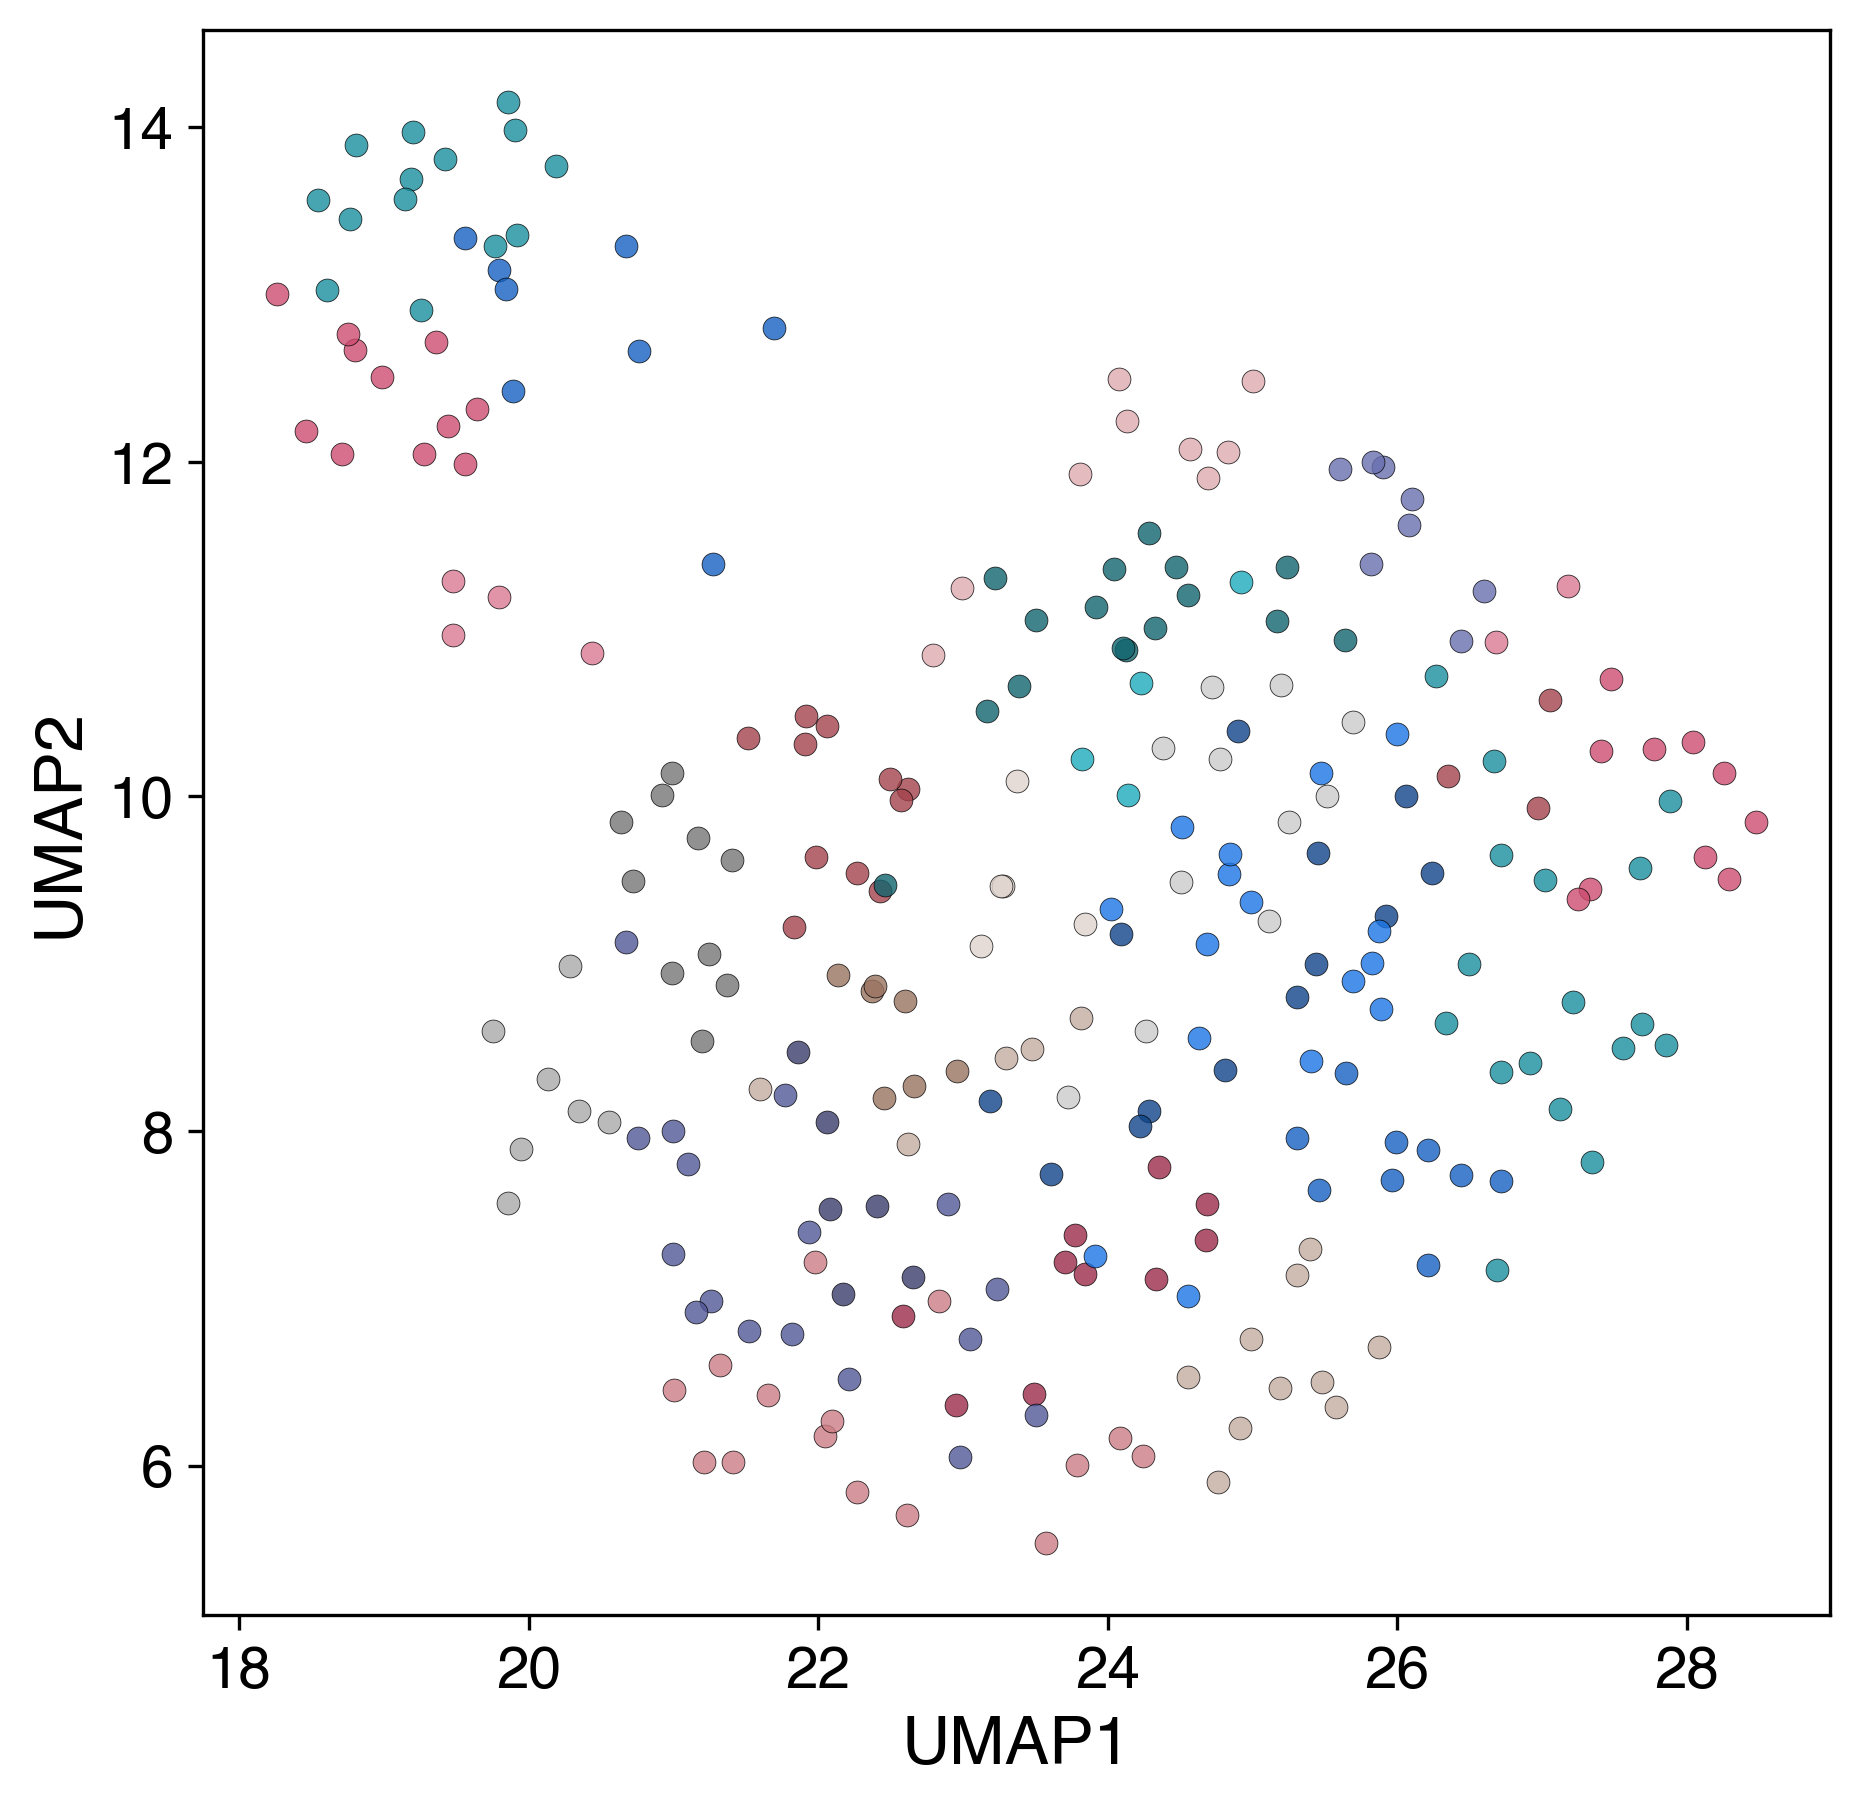

Please note that some colors only differ in the shade and some colors are also repeated to the large number of clusters.


In [28]:
# draw the clusters
print("Visualization of the clusters:")

# making sure there are enough colors
all_colors = all_colors * 4

plt.figure(figsize=(7,7),dpi=300)
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

for cluster_id in sorted(df_umap['clusters'].unique()):
    color_id = cluster_id-1  # colors are zero-index, but clusters one-indexed
    cluster_data = df_umap[df_umap['clusters'] == cluster_id]
    plt.scatter(
        cluster_data['UMAP1'], cluster_data['UMAP2'],
        color=all_colors[color_id],
        label=f'Cluster {cluster_id}',
        s=30, alpha=0.8, edgecolor='k', linewidth=0.2
    )
plt.show()
print("Please note that some colors only differ in the shade and"\
      " some colors are also repeated to the large number of clusters.")

In [29]:
# calculate the center-most point of each cluster and the Vendi score for the resulting samples
scope_results27 = pd.DataFrame(np.nan,index=["Results"],columns=["Average yield (%)","Vendi score","Scope score"])

cluster_yields = [] # list to save the yields
df_vendi = df_labelled.copy(deep=True)
df_vendi["yield"] = "PENDING"  # reset the yield data so that only the selected points will have a yield
for cluster in range(max(df_data["clusters"].unique())):  # loop through all clusters
    cluster = cluster+1  # +1 because the range object is 0-indexed whereas the cluster are 1-indexed
    df_cluster = df_data.loc[df_data["clusters"]== cluster]  # look at the points in the current cluster
    df_cluster = df_cluster.drop(columns=["clusters"])  # drop the cluster column to only keep the features (df_data did not contain the yield data)
    centroid = df_cluster.mean().values  # this is the center of the cluster
    distances = cdist(df_cluster,[centroid],metric="cityblock").flatten()  # calculate the distances to the center
    df_cluster["distances"] = distances
    centermost_point = df_cluster[df_cluster["distances"] == df_cluster["distances"].min()].index.item()  # get the center-most point
    yield_clusterpoint = df_labelled.at[centermost_point,"yield"]  # get the yield data for the center-most point
    df_vendi.loc[centermost_point,"yield"] = "1"  # put a label for the vendi score calculation (value is not important)
    cluster_yields.append(yield_clusterpoint)  # save the point
av_yield = sum(cluster_yields)/len(cluster_yields)
scope_results27.loc["Results","Average yield (%)"] = av_yield
df_vendi.to_csv(wdir.joinpath("df_data_vendi.csv"),index=True,header=True)  # save the file (as the Vendi score calculation needs a file as input)
Vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],directory=".",filename="df_data_vendi.csv")  # calculate the vendi score
scope_results27.loc["Results","Vendi score"] = Vendi_score
scope_score = calculate_scope_score(av_yield,Vendi_score,bounds)
scope_results27.loc["Results","Scope score"] = scope_score

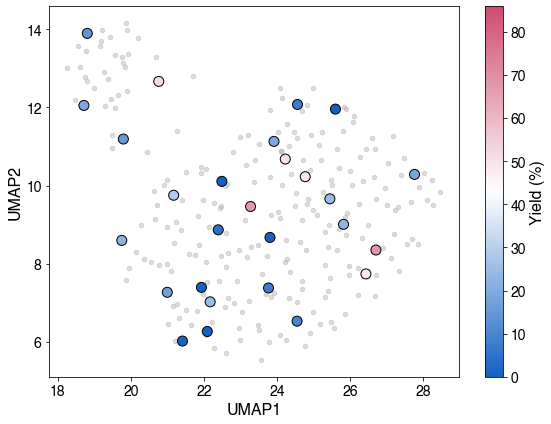

Scope results:


Average yield (%)  Vendi score  Scope score
Results          21.881481     2.258444     0.042796

In [30]:
plt.figure(figsize=(8,6))
plt.xlabel("UMAP1",fontsize=16)
plt.ylabel("UMAP2",fontsize=16)

# only keep the objective label for evaluated points
df_umap["yield"] = df_labelled["yield"]

for idx in df_vendi.index:
    if df_vendi.loc[idx,"yield"] == "PENDING":
        df_umap.loc[idx,"yield"] = "PENDING"

# Separate numeric and non-numeric (e.g., "PENDING") entries
df_numeric = df_umap[pd.to_numeric(df_umap['yield'], errors='coerce').notna()].copy()
df_numeric['yield'] = df_numeric['yield'].astype(float)
df_pending = df_umap[pd.to_numeric(df_umap['yield'], errors='coerce').isna()]

# Define colormap and normalization
vmin = df_labelled['yield'].min()
vmax = df_labelled['yield'].max()
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("Doyle_cont", as_cmap=True)

# Plot non-numeric entries ("PENDING")
plt.scatter(df_pending["UMAP1"], df_pending["UMAP2"], color=all_colors[6], s=20, alpha=0.4, label="PENDING")
# Plot numeric entries
scatter_numeric = plt.scatter(df_numeric["UMAP1"],df_numeric["UMAP2"],c=df_numeric["yield"],cmap=cmap,norm=norm,s=100,alpha=1,edgecolor='k',linewidth=1)
# Add colorbar
cbar = plt.colorbar(scatter_numeric)
cbar.set_label("Yield (%)")

plt.tight_layout()
plt.show()
print("Scope results:")
scope_results27

The average yield drops strongly compared to the 16-sample clustering scope whereas the Vendi score only increases slightly depite 11 additional samples.

Selected scope:


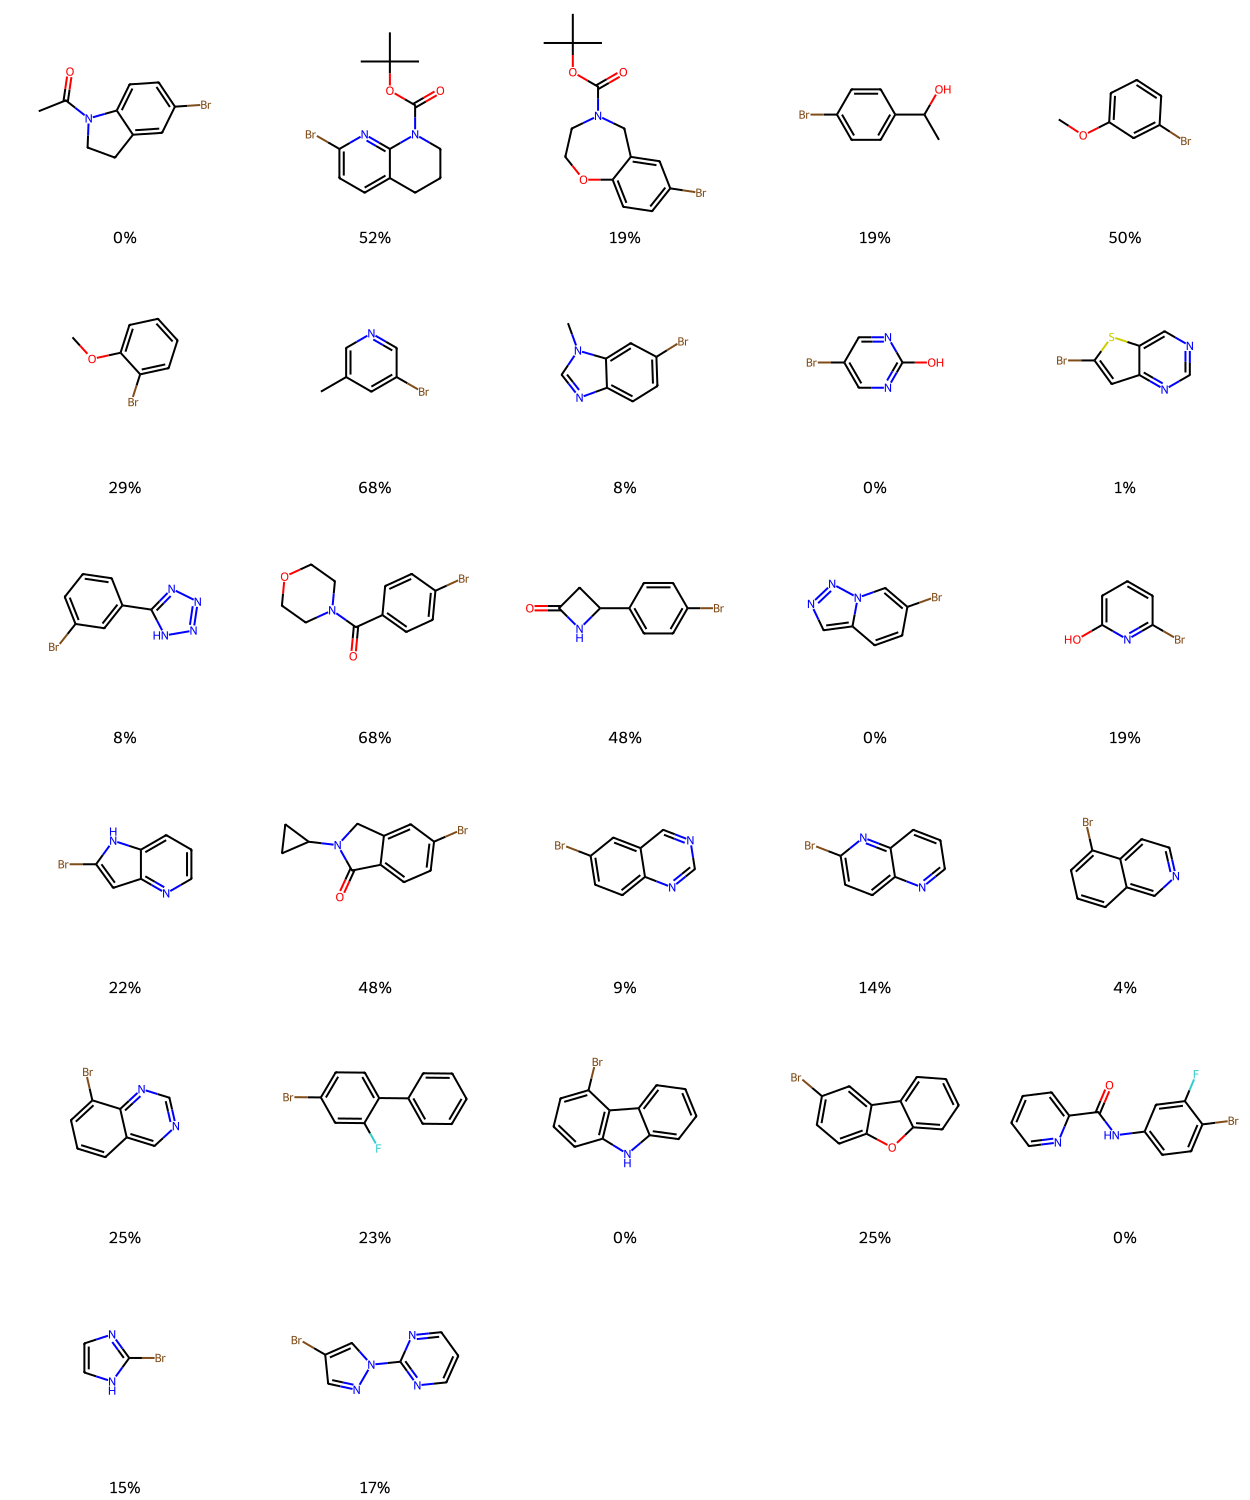

In [31]:
print("Selected scope:")
df_selected = df_umap.loc[df_umap["yield"] != "PENDING"]
mol_list = generate_representation(list(df_selected.loc[df_selected["yield"] != "PENDING"].index))
depiction = Draw.MolsToGridImage(
    mol_list,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=[f"{round(df_selected.loc[smiles,'yield'])}%" for smiles in df_selected.index]
    )
display(depiction)

### Clustering scopes using Glorius' approach

In [32]:
def assign_clusterpoints(df_clusterpoints,df_dataset):
    """Assigns the selected cluster points to the dataset by comparison of canonical smiles. 
    Also assigns the yield labels to the cluster points dataframe."""
    # generate a new column with canonical smiles in both dataframes
    df_data = df_dataset.copy()
    for df in [df_clusterpoints,df_data]:
        smiles_labelled = list(df.index)
        mol_labelled = [Chem.MolFromSmiles(smiles) for smiles in smiles_labelled]
        can_labelled = [Chem.MolToSmiles(mol,canonical=True, isomericSmiles=False) for mol in mol_labelled]  # canonical smiles
        df["can"] = can_labelled
    
    # only keep the rate labels for datapoints in the df_clusterpoints
    df_data.loc[~df_data["can"].isin(set(df_clusterpoints["can"])),"yield"] = 'PENDING'

    # assign the rate labels to df_clusterpoints
    for smiles in df_clusterpoints["can"]:
        df_clusterpoints.loc[df_clusterpoints["can"]==smiles,"yield"] = df_data.loc[df_data["can"]==smiles,"yield"].values[0]

    df_data.drop(axis=1,labels="can",inplace=True)
    df_clusterpoints.drop(axis=1,labels="can",inplace=True)

    return df_clusterpoints, df_data


In [33]:
def umap_representation(data_clust,ax,dict_class = None):
    """Creates a plt axes object with the selected samples visualized on a UMAP."""
    df_umap = pd.read_csv(f"./../XEC_data/Datasets/xec_dft_umap_bromide_scope_pruned.csv",index_col=0,header=0)
     # assign the yields
    df_umap["yield"] = df_labelled["yield"]

    # Define colormap and normalization
    vmin = df_umap['yield'].min()
    vmax = df_umap['yield'].max()
    norm = plt.Normalize(vmin, vmax)
    cmap = sns.color_palette("Doyle_cont", as_cmap=True)

    full_scope = data_clust.index.to_list()
    if dict_class is not None:
        full_scope += list(dict_class.keys())

    # assign scope samples
    df_umap["status"] = "none"
    if dict_class is not None:
        df_umap.loc[df_umap.index.isin(set(dict_class.keys())), "status"] = "classical"
    df_umap.loc[df_umap.index.isin(data_clust[data_clust["yield"] != "PENDING"].index), "status"] = "clustering"

    # remove rates for non-selected compounds
    df_umap.loc[df_umap["status"] == "none", "yield"] = "PENDING"


    # Plot the non-selected samples
    df_map_pending = df_umap.loc[df_umap["status"] == "none"].copy()
    ax.scatter(df_map_pending["UMAP1"], df_map_pending["UMAP2"], color=all_colors[6], s=20, alpha=0.4, label="not selected")

    # Plot entries of the clustering scope
    df_map_clust = df_umap.loc[df_umap["status"] == "clustering"].copy()

    scatter_cluster = ax.scatter(df_map_clust["UMAP1"],df_map_clust["UMAP2"], label="clustering",
                                 c=df_map_clust["yield"],cmap=cmap,norm=norm, marker="o",
                                 s=100,alpha=1,edgecolor='k',linewidth=1)
    
    # Plot entries of the classical scope (if is exists)
    if dict_class is not None:
        df_map_class = df_umap.loc[df_umap["status"] == "classical"].copy()
        ax.scatter(df_map_class["UMAP1"],df_map_class["UMAP2"], label = "classical",
                                    c=df_map_class["yield"],cmap=cmap,norm=norm,marker="s",
                                    s=100,alpha=1,edgecolor='k',linewidth=1)

    # Add colorbar
    cbar = fig.colorbar(scatter_cluster,ax=ax)
    cbar.set_label("Yield (%)")

    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")

The scope was created using the webapp https://pharmascope.uni-muenster.de/ using the recommended settings (15 clusters to generate 15 compounds and using the provided standard UMAP 0_ECFP_2_512_UMAP_2dim_30nb_0.1mindist_jaccard.model).

In [34]:
# the clustering algorithm by Glorius and co-workers takes SMILES strings of the substrates as the input.

# Load the smiles list
# create the input smiles list for the webapp
pd.DataFrame(df_labelled.index.to_list(),index=None,columns=None).to_csv(
    f"./Results_Data/cluster_scope/xec_bromide_scope_smiles_list.txt", index=False, header=False)

A list of the SMILES strings of all ArBr in the dataset was provided as the input and the top-1 substrate per cluster was requested.

After using the webapp, the results can be read in.

Substrates selected by the clustering algorithm using 15 clusters:


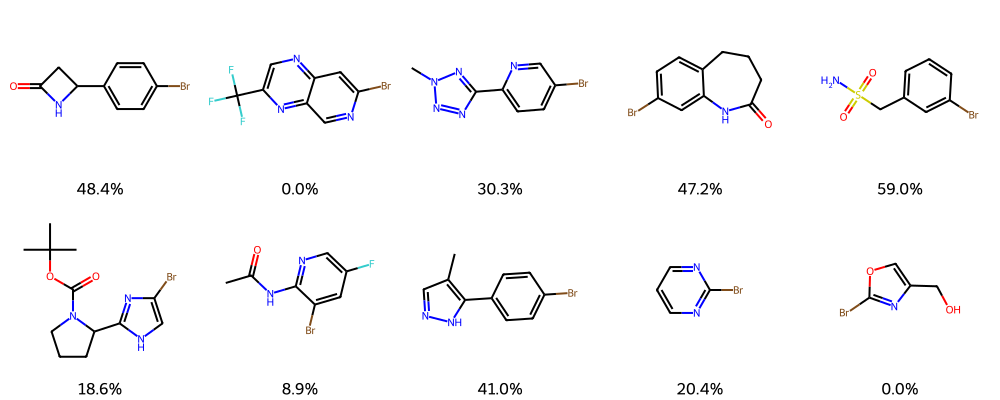

Number of selected compounds: 10


In [35]:
scope_results_15clu = pd.DataFrame(np.nan,index=["Results"],columns=["Scope size",
                                                                     "Average yield (%)",
                                                                     "Vendi score","Scope score"])
df_clustering = pd.read_csv(f"./Results_Data/cluster_scope/glorius_selected_15clu.csv",
                                    index_col=0,header=0)
df_clustering.set_index("smiles",inplace=True)



df_clustering, df_data = assign_clusterpoints(df_clusterpoints=df_clustering,df_dataset=df_labelled)

mol_list = generate_representation(list(df_clustering.index))
depiction = Draw.MolsToGridImage(
    mol_list,
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{df_clustering.loc[smiles,'yield']:.1f}%" for smiles in df_clustering.index]
    )
print(f"Substrates selected by the clustering algorithm using 15 clusters:")
display(depiction)

print(f'Number of selected compounds: {len(df_clustering)}')
scope_results_15clu.loc["Results","Scope size"] = len(df_clustering)

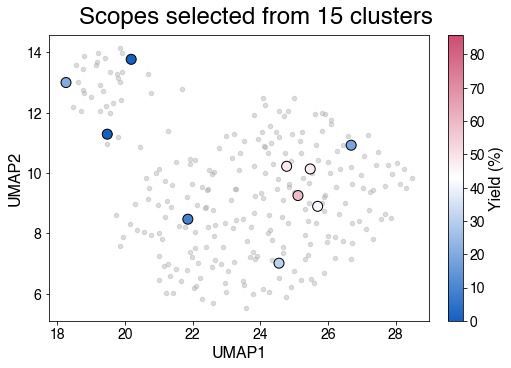

Scope size  Average yield (%)  Vendi score  Scope score
Results        10.0               27.4        2.745        0.197

In [36]:
fig,axes = plt.subplots(figsize=(7,5),gridspec_kw={"wspace":0.1},constrained_layout=True)
fig.suptitle("Scopes selected from 15 clusters")
av_yield = df_clustering["yield"].mean()
scope_results_15clu.loc["Results","Average yield (%)"] = round(av_yield,1)
df_data.to_csv("df_vendi.csv",index=True,header=True)
vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
scope_results_15clu.loc["Results","Vendi score"] = round(vendi_score,3)
bounds = bounds
scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
scope_results_15clu.loc["Results","Scope score"] = round(scope_score,3)
umap_representation(df_data,axes)
plt.show()
scope_results_15clu

The average yield is very high so that the final scope score is high despite the mediocre Vendi score. As the scope of 10 samples is however very small and also below the recommendation from Glorius and co-workers (who suggested 15 samples from 15 clusters), we repeated the clustering with larger cluster sizes until 15 samples were generated. This was the case after 24 clusters.

Substrates selected by the clustering algorithm using 24 clusters (15 samples generated):


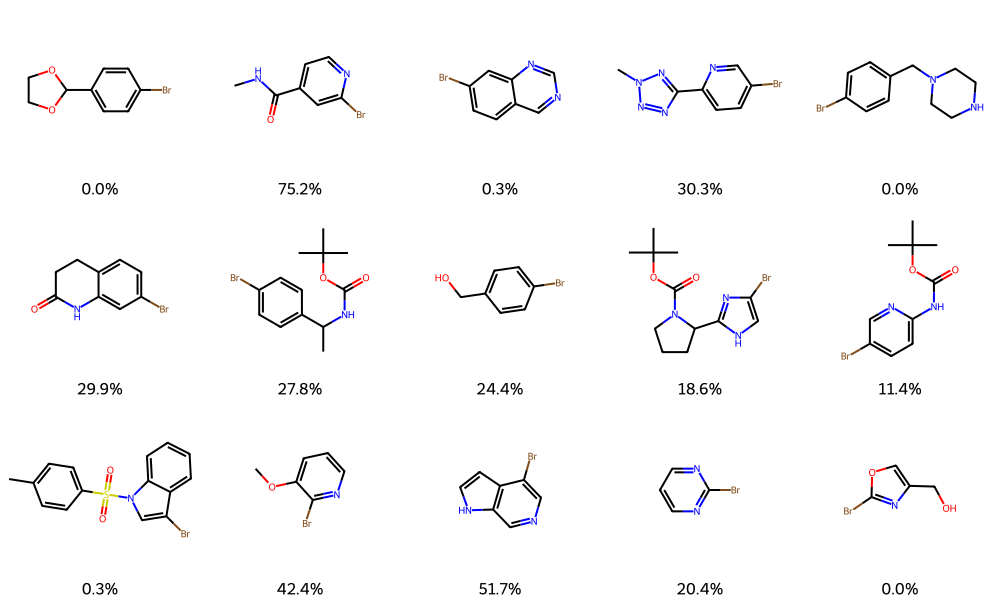

Number of selected compounds: 15


In [37]:
scope_results_15sam = pd.DataFrame(np.nan,index=["Results"],columns=["Scope size",
                                                                     "Average yield (%)",
                                                                     "Vendi score","Scope score"])
df_clustering = pd.read_csv(f"./Results_Data/cluster_scope/glorius_selected_15sam.csv",
                                    index_col=0,header=0)
df_clustering.set_index("smiles",inplace=True)



df_clustering, df_data = assign_clusterpoints(df_clusterpoints=df_clustering,df_dataset=df_labelled)

mol_list = generate_representation(list(df_clustering.index))
depiction = Draw.MolsToGridImage(
    mol_list,
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"{df_clustering.loc[smiles,'yield']:.1f}%" for smiles in df_clustering.index]
    )
print(f"Substrates selected by the clustering algorithm using 24 clusters (15 samples generated):")
display(depiction)

print(f'Number of selected compounds: {len(df_clustering)}')
scope_results_15sam.loc["Results","Scope size"] = len(df_clustering)

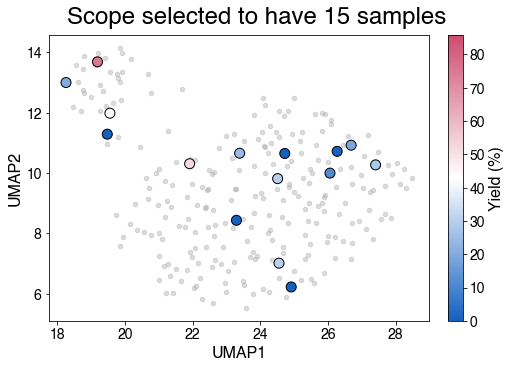

Scope size  Average yield (%)  Vendi score  Scope score
Results        15.0               22.2        2.793        0.121

In [39]:
fig,axes = plt.subplots(figsize=(7,5),gridspec_kw={"wspace":0.1},constrained_layout=True)
fig.suptitle("Scope selected to have 15 samples")
av_yield = df_clustering["yield"].mean()
scope_results_15sam.loc["Results","Average yield (%)"] = round(av_yield,1)
df_data.to_csv("df_vendi.csv",index=True,header=True)
vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
scope_results_15sam.loc["Results","Vendi score"] = round(vendi_score,3)
bounds = bounds
scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
scope_results_15sam.loc["Results","Scope score"] = round(scope_score,3)
umap_representation(df_data,axes)
plt.show()
scope_results_15sam

The average yield decreased while the Vendi score did not increase significantly, leading to a decrease in the scope score.

Do a "short classical scope" (here simulated as 20 samples selected with greedy acquisition with 5% Vendi pruning) in combination with a clustering scope of 15 samples. This combination was recommended by Glorius and co-workers

In [ ]:
# Benchmark().collect_data(
#     filename_labelled = "./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
#     name_results = f"./Results_Data/cluster_scope/glorius_class_scope",
#     objectives=['yield'],
#     budget = 20,
#     batches= [2],
#     Vendi_pruning_fractions = [5],
#     seeds = 40,
#     acquisition_function_mode= "greedy",
#     pruning_metric="vendi_batch",
#     init_sampling_method="random"
#     )

Find the random initiation that gives an average scope performance.

In [40]:
# find the scope that gives an average scope score
initiation = "random_initiation"
classical_scope = pd.DataFrame(np.nan,index=["Results"],columns = ["Seed", "Seed average yield (%)", "Seed Vendi score",
                                                                "Seed scope score","Average scope score"])

# get the data for the inidividual seeds
_, dict_dfs_raw_data = Benchmark.get_metric_overview(bounds=bounds,budget=20,type_results="scope", 
                            name_results=f"./Results_Data/cluster_scope/glorius_class_scope")

# dict_dfs_raw_data contains the a dict for each batch-pruning 
# combination which in turn contains a dict of the raw data for the differnt random seeds
# --> restrict to the relevant data (batch size 2 and no Vendi pruning)
dfs_raw_data = dict_dfs_raw_data["b2_V5"]

# collect the scope scores and other metrics
# NOTE: the indices are the (zero-indexed) rounds --> round 9 is the full scope of 20 samples
score_dict = {seed: df.loc[9,"scope"] for seed,df in dfs_raw_data.items()}
yield_dict = {seed: df.loc[9,"yield"] for seed,df in dfs_raw_data.items()}
vendi_dict = {seed: df.loc[9,"vendi"] for seed,df in dfs_raw_data.items()}
av_score = np.mean(np.array(list(score_dict.values())))
classical_scope.loc["Results","Average scope score"] = av_score

# calculate the absolute difference to the average score
score_diff = {seed: abs(score-av_score) for seed,score in score_dict.items()}

# get the seed that is closest to the average
av_seed = min(score_diff,key=score_diff.get)
classical_scope.loc["Results","Seed"] = av_seed
classical_scope.loc["Results","Seed scope score"] = score_dict[av_seed]
classical_scope.loc["Results","Seed Vendi score"] = vendi_dict[av_seed]
classical_scope.loc["Results","Seed average yield (%)"] = yield_dict[av_seed]
classical_scope

Seed  Seed average yield (%)  Seed Vendi score  Seed scope score  \
Results  25.0                  21.235          2.238936           0.03633   

         Average scope score  
Results              0.03319

After picking this classical scope, we removed the selected sample from the searchspace and carried out the clustering on the remaining samples

In [41]:
# remove the samples that were selected in the classical scope from the options presented to the clustering algorithm
classical_smiles = {}

# get the scope
seed = int(classical_scope.loc["Results","Seed"])
df_classical = pd.read_csv(f"Results_Data/cluster_scope/glorius_class_scope/raw_data/20greedy_b2_V5_s{seed}.csv", 
                            index_col=0, header=0)
df_classical["eval_samples"] = df_classical["eval_samples"].apply(lambda x: [y.strip("'") for y in x[1:-1].split(', ')])


# record the selected smiles
smiles_list = [smiles for round_list in [df_classical.loc[round,"eval_samples"] 
                                            for round in df_classical.index] for smiles in round_list]
smiles_list = [smiles.encode().decode('unicode_escape') for smiles in smiles_list]

# load the full smiles list for the dataset
full_smiles_list = df_labelled.index.to_list()
# record the smiles, rates for the classical scope
classical_smiles = {smiles: df_labelled.loc[smiles,"yield"] for smiles in smiles_list}

# remove the compounds that were already selected
for smiles in smiles_list:
    full_smiles_list.remove(smiles)
pd.DataFrame(full_smiles_list,index=None,columns=None).to_csv(
    f"./Results_Data/cluster_scope/glorius_smiles_list_classical.txt",index=False,header=False)

15 subsequent clustering samples were generated using 24 clusters in the webapp.

Substrates selected as the classical scope:


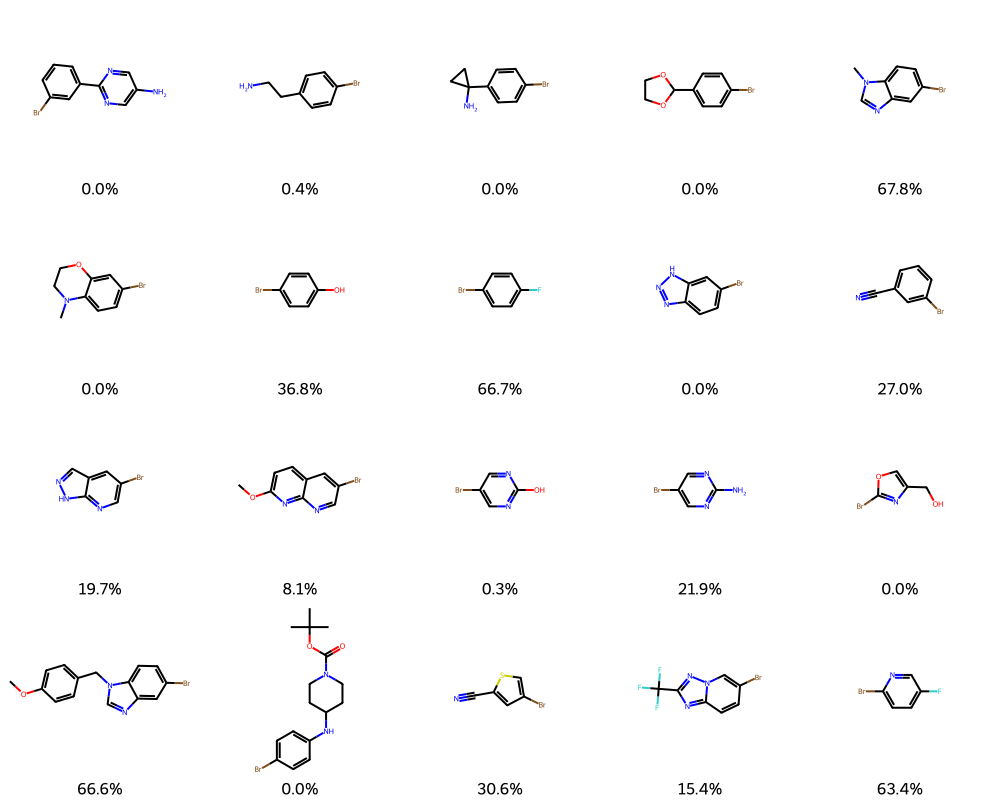

Substrates selected by the subsequent clustering algorithm:


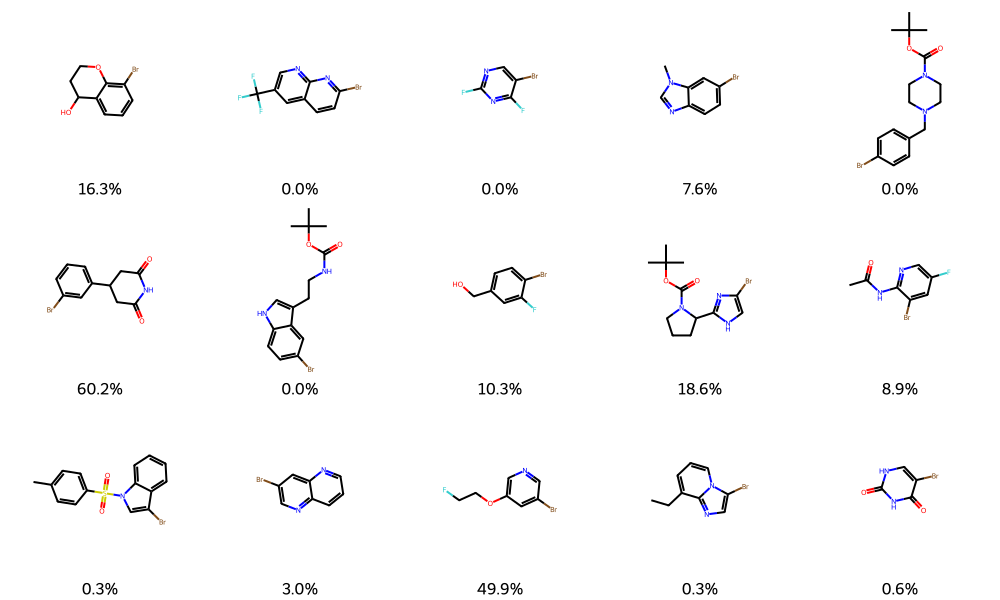

In [42]:
df_clustering = pd.read_csv(f"./Results_Data/cluster_scope/glorius_selected_15comb.csv",index_col=0,header=0)
df_clustering.set_index("smiles",inplace=True)

df_clustering, df_data_clust = assign_clusterpoints(df_clusterpoints=df_clustering,df_dataset=df_labelled)

for results_type in ["class","clust"]:
    if results_type == "class":
        mol_list = generate_representation(list(classical_smiles.keys()))
        print(f"Substrates selected as the classical scope:")
        legends = [f"{yield_val:.1f}%" for yield_val in classical_smiles.values()]
    elif results_type == "clust":
        mol_list = generate_representation(list(df_clustering.index))
        print(f"Substrates selected by the subsequent clustering algorithm:")
        legends = [f"{df_clustering.loc[smiles,'yield']:.1f}%" for smiles in df_clustering.index]
    depiction = Draw.MolsToGridImage(
        mol_list,
        molsPerRow=5,
        subImgSize=(200, 200),
        legends=legends
        )
    display(depiction)

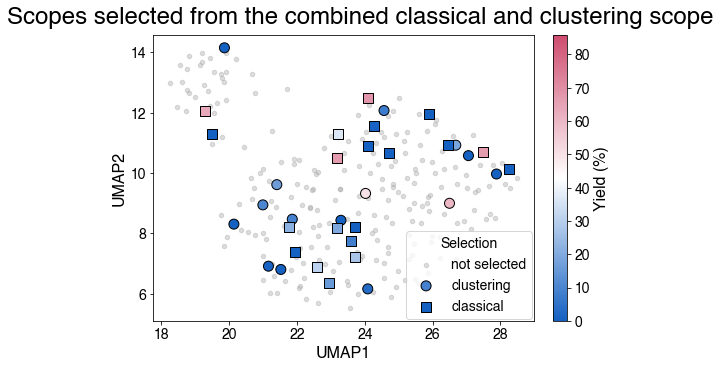

Results for the combined scope of first 20-sample classical scope and then a 15-sample clustering scope:


Average yield (%)  Vendi score  Scope score (combined scope)
Results               17.2        2.757                         0.034

In [43]:
# df to record results
scope_results_class = pd.DataFrame(np.nan,index=["Results"],columns=["Average yield (%)", "Vendi score",
                                                                  "Scope score (combined scope)"])

fig,axes = plt.subplots(figsize=(7,5),constrained_layout=True)
fig.suptitle("Scopes selected from the combined classical and clustering scope")

# combine the two scopes
data_full = df_data_clust.copy()
for idx in data_full.index:
    if idx in classical_smiles.keys():
        data_full.loc[idx,"yield"] = classical_smiles[idx]

av_yield = data_full[data_full["yield"] != "PENDING"]["yield"].mean()
scope_results_class.loc["Results","Average yield (%)"] = round(av_yield,1)
data_full.to_csv("df_vendi.csv",index=True,header=True)
vendi_score = ScopeBO().get_vendi_score(objectives=["yield"],filename="df_vendi.csv")
scope_results_class.loc["Results","Vendi score"] = round(vendi_score,3)
scope_score = calculate_scope_score(av_yield,vendi_score,bounds)
scope_results_class.loc["Results","Scope score (combined scope)"] = round(scope_score,3)
umap_representation(df_data_clust,axes,classical_smiles)
handles_collected, labels_collected = axes.get_legend_handles_labels()
plt.legend(handles=handles_collected, labels=labels_collected, title = "Selection",
           fontsize=14, loc='center', bbox_to_anchor=(0.83, 0.16))
plt.show()
print("Results for the combined scope of first 20-sample classical scope and then a 15-sample clustering scope:")
scope_results_class

The Vendi score is not particularly high and the average yield is fairly low, resulting a low scope score.

### Benchmark comparisons

Collect the data

In [44]:
acq_fct = ["EI","Random","Greedy","Conv. selection"]
pruning_opt = [False,True]
datasets = ["high","medium","low"]

map_data = {}
std_data = {}
for acq in acq_fct:
    if acq == "Conv. selection":
        acq_label =  "human-like-acq"
    elif acq == "Random":
        acq_label = "random-selection"
    else:
        acq_label = acq.lower()
    for pruning in [True,False]:
        if pruning:
            pruning_label = "_with-pruning"
        else:
            pruning_label = "_no-pruning"
        if acq == "Conv. selection":
            pruning_label = ""
        run_results = []
        std_results = []
        for type_results in ["Objective","Vendi","Scope"]:
            dfs_scaled,_ = Benchmark.get_metric_overview(budget=27,type_results=type_results,
                                            name_results=f"Results_Data/results_pruned/scope_{acq_label}{pruning_label}",
                                            scope_method="product", objective_weights=None, bounds = bounds, directory=".")
            run_results.append(dfs_scaled["means"].iloc[-1,0])  # save the last mean which is the result at the end of the scope
            std_results.append(dfs_scaled["stdev"].iloc[-1,0])  # same for the standard deviation of the result
        map_data[f"{acq}{pruning_label}"] = run_results
        std_data[f"{acq}{pruning_label}"] = std_results
map_df = pd.DataFrame.from_dict(map_data)
std_df = pd.DataFrame.from_dict(std_data)

# add clustering data
# col 0 is averaged objectives; 1 is Vendi score; 2 is scope score
map_df["Doyle_clustering"] = [scope_results.iloc[0,0],scope_results.iloc[0,1],scope_results.iloc[0,2]]
std_df["Doyle_clustering"] = [0,0,0]  # no std as only one deterministic run
# col 1 is averaged objectives; 2 is Vendi score; 3 is scope score
map_df["Glorius_clustering"] = [scope_results_15sam.iloc[0,1],scope_results_15sam.iloc[0,2],
                                scope_results_15sam.iloc[0,3]]
std_df["Glorius_clustering"] = [0,0,0]  # no std as only one deterministic run

Table summaries

In [45]:
new_index = ["Average yield (%)", "Vendi score", "Scope score"]
new_cols = ["ScopeBo", "EI", "Random (pruned)", "Random", "Greedy (pruned)", 
            "Greedy", "Conv. selection", "Doyle clustering", "Glorius clustering"]
map_df.index = new_index
map_df.columns = new_cols
map_df

ScopeBo         EI  Random (pruned)     Random  \
Average yield (%)  18.793241  18.858704        18.666019  21.898241   
Vendi score         3.744610   3.364691         3.000620   2.262595   
Scope score         0.128322   0.107310         0.071357   0.039558   

                   Greedy (pruned)     Greedy  Conv. selection  \
Average yield (%)        23.848333  30.515741        27.877407   
Vendi score               2.796943   1.936474         2.252477   
Scope score               0.134423  -0.023358         0.065414   

                   Doyle clustering  Glorius clustering  
Average yield (%)         28.850000              22.200  
Vendi score                2.050944               2.793  
Scope score                0.029446               0.121

In [48]:
std_df.index = new_index
std_df.columns = new_cols
std_df.applymap(lambda x: round(x,3)).T

Average yield (%)  Vendi score  Scope score
ScopeBo                         4.273        0.212        0.151
EI                              4.243        0.312        0.132
Random (pruned)                 3.391        0.230        0.073
Random                          3.952        0.315        0.054
Greedy (pruned)                 4.885        0.327        0.077
Greedy                          5.798        0.363        0.089
Conv. selection                 5.705        0.297        0.057
Doyle clustering                0.000        0.000        0.000
Glorius clustering              0.000        0.000        0.000

Plotting the results

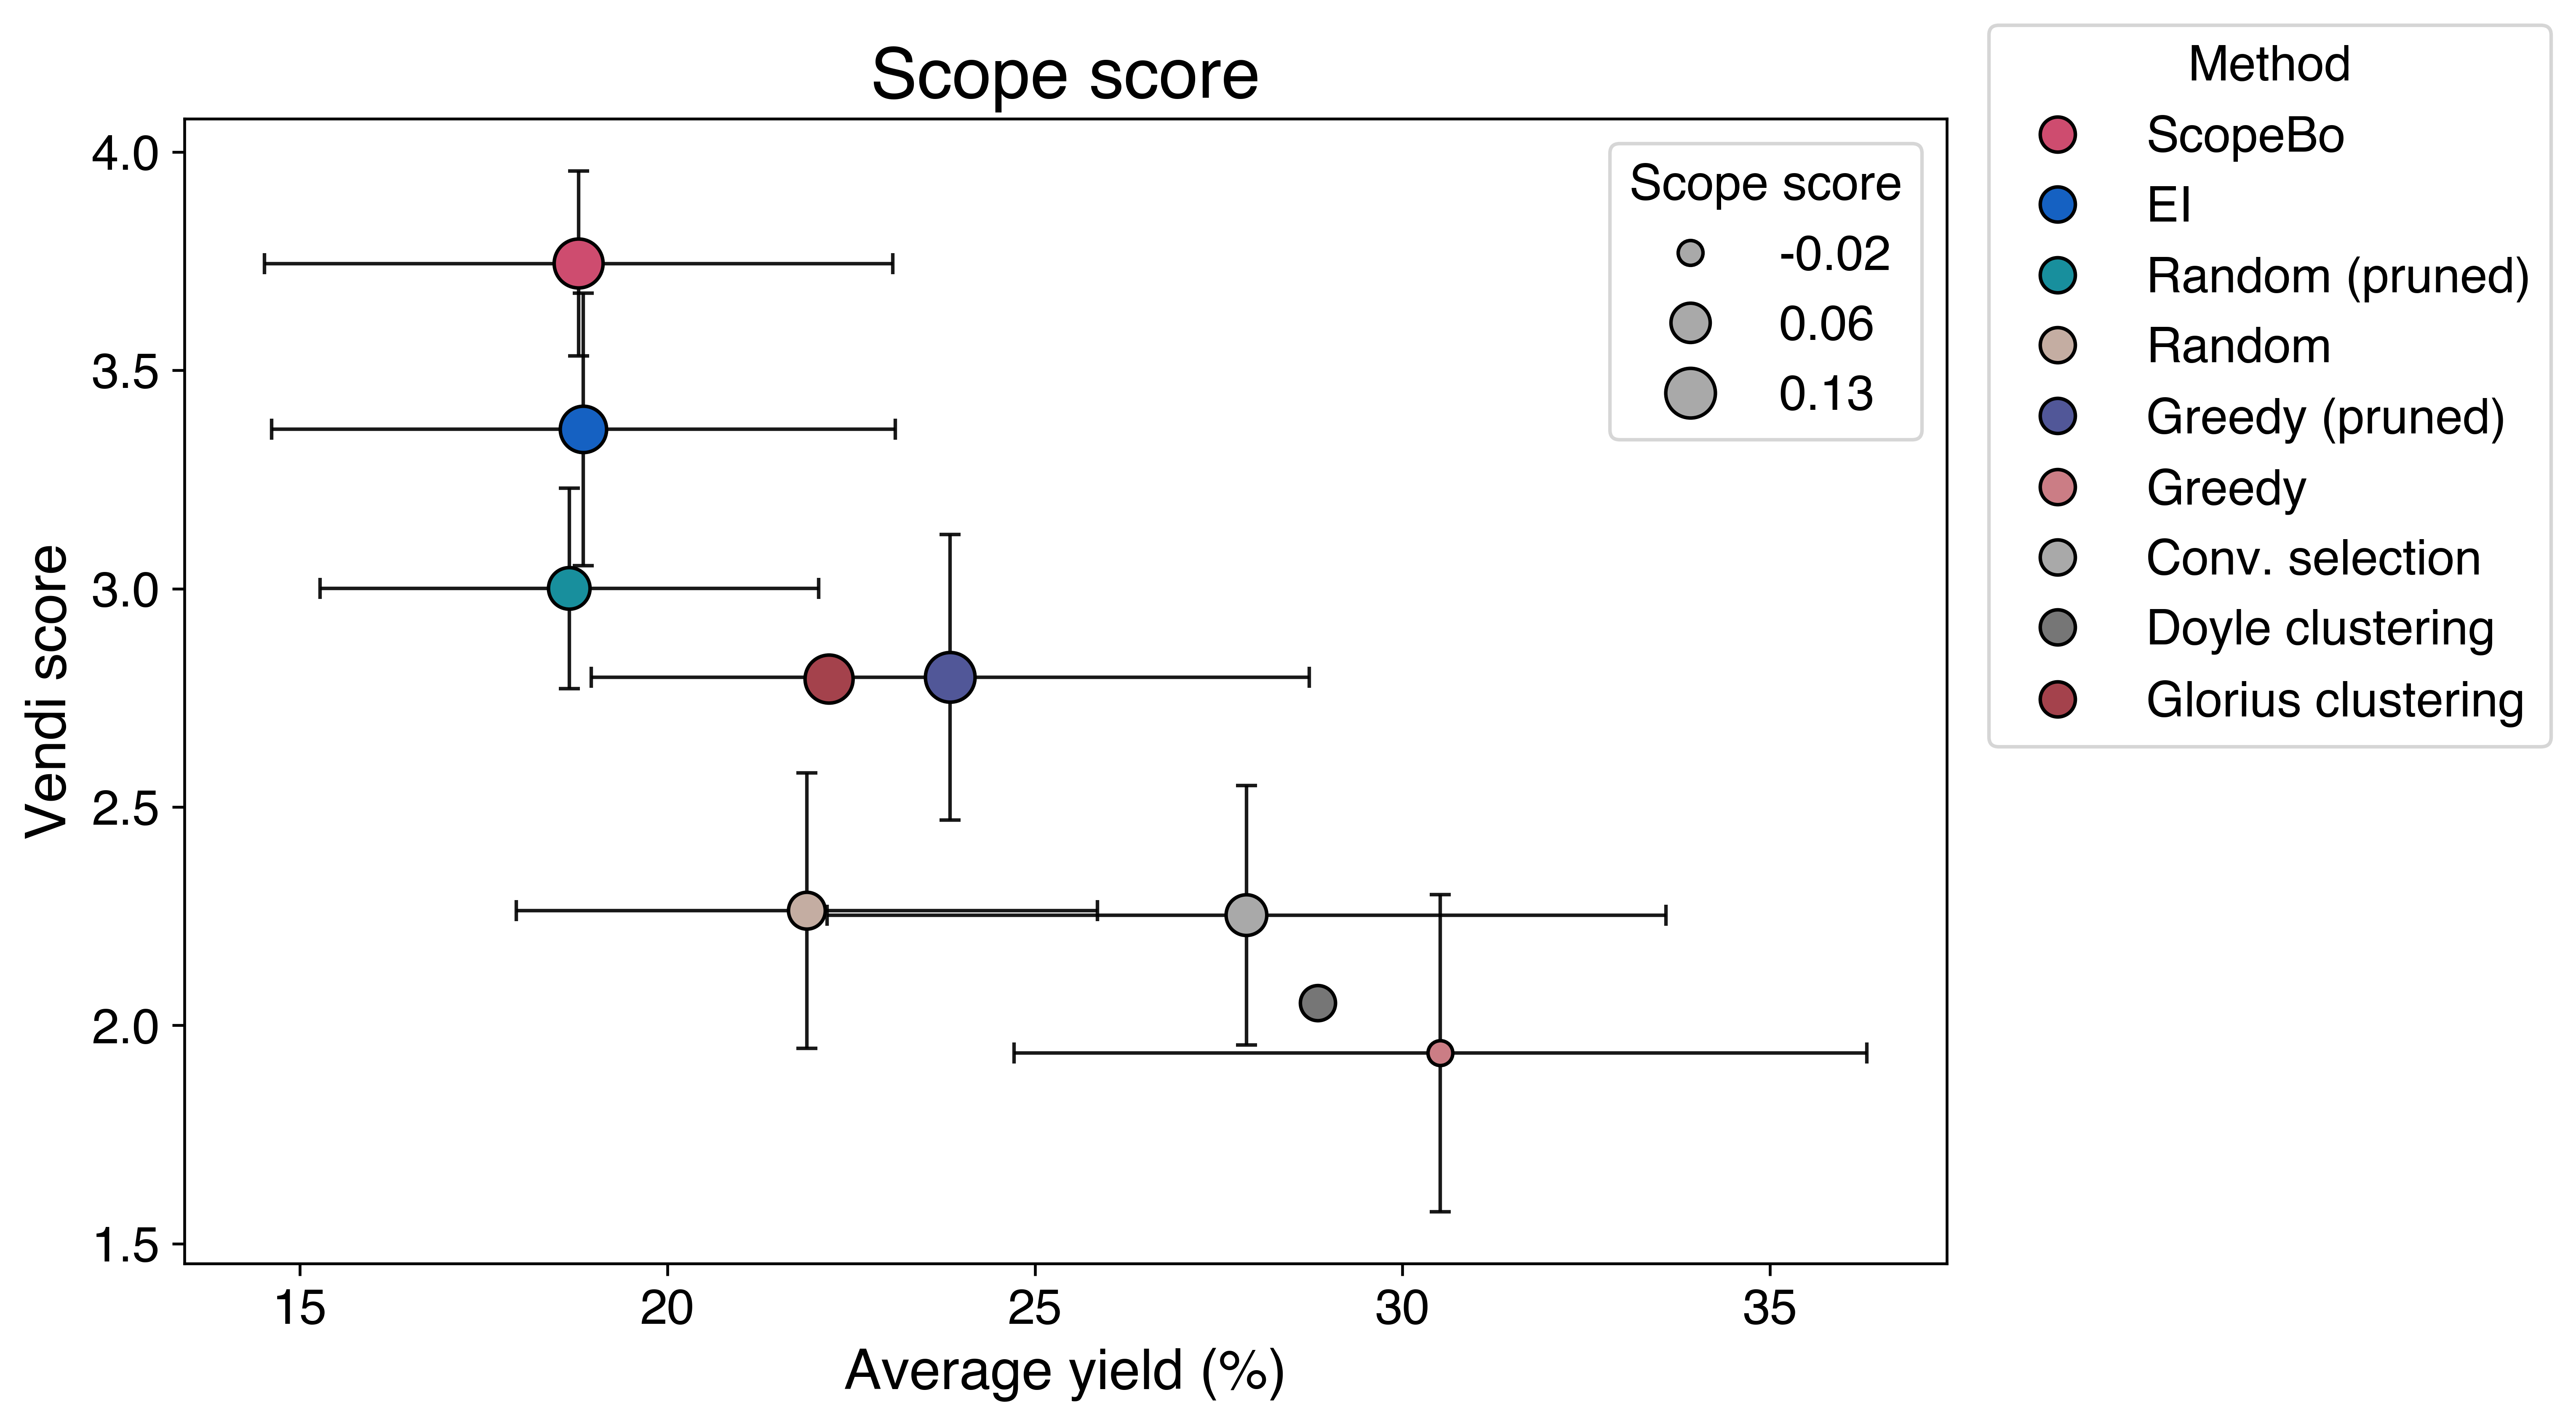

Average yield (%)  Vendi score  Scope score
ScopeBo                        18.793        3.745        0.128
EI                             18.859        3.365        0.107
Random (pruned)                18.666        3.001        0.071
Random                         21.898        2.263        0.040
Greedy (pruned)                23.848        2.797        0.134
Greedy                         30.516        1.936       -0.023
Conv. selection                27.877        2.252        0.065
Doyle clustering               28.850        2.051        0.029
Glorius clustering             22.200        2.793        0.121

In [47]:
# Plot the results
x = map_df.iloc[0]
y = map_df.iloc[1]
xerr = std_df.iloc[0]
yerr = std_df.iloc[1]
raw_size_data = map_df.iloc[2]

size_min, size_max = 50, 200
data_min, data_max= raw_size_data.min(), raw_size_data.max()
sizes = size_min + (raw_size_data - data_min) * (size_max - size_min) / (data_max - data_min)

# simplify the labels for the legend
labels = map_df.columns
labels = list(labels)
for i,val in enumerate(labels):
    if val == "EI_pruning":
        labels[i] = "ScopeBO"
    elif "no-pruning" in val:
        labels[i] = val.split("_")[0]
    elif "_pruning" in val:
        labels[i] = val.split("_")[0] + " (pruned)"
map_df.columns = labels


color_map = {label: all_colors[i] for i, label in enumerate(labels)}
colors = [color_map[label] for label in labels]
alpha_val = 1

plt.figure(figsize=(9,6),dpi=600)
plt.title(f"Performance map")
plt.scatter(x, y, s=sizes, alpha=alpha_val, c = colors, edgecolors="k")
# Add error bars
plt.errorbar(
    x, y,
    xerr=xerr,
    yerr=yerr,
    fmt='none',
    ecolor='black',
    elinewidth=1,
    capsize=3,
    alpha=0.9,
    zorder=0
)


plt.xlabel('Average yield (%)')
plt.ylabel('Vendi score')
plt.title('Scope score')

# legend for the methods
color_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=label,
        markerfacecolor=color_map[label],
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=10
    )
    for label in labels
]

# legend for scope score
# Choose representative raw size values
size_legend_values = np.linspace(raw_size_data.min(), raw_size_data.max(), 3)
size_legend_sizes = size_min + (size_legend_values - data_min) * (size_max - size_min) / (data_max - data_min)
size_legend = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{val:.2f}',
        markerfacecolor=all_colors[6],
        alpha=alpha_val,
        markeredgecolor='k',
        markersize=np.sqrt(s)
    )
    for val, s in zip(size_legend_values, size_legend_sizes)
]

# Add legends
first_legend = plt.legend(handles=color_legend, loc = "lower left", title="Method", frameon=True,
                          bbox_to_anchor=(1.01, 0.43))
plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=size_legend, title="Scope score", frameon=True)

plt.show()

map_df.index = ["Average yield (%)", "Vendi score", "Scope score"]
map_df.applymap(lambda x: round(x,3)).T

### Visualization of scopes

Show the scopes for the random seed that provides a scope performance closest to the average of all random seeds (for ScopeBO scopes).

In [49]:
def find_av_random_seed(name_results, bounds, batch_pruning, budget=27):
    """Finds the random seed that give the scope with a scope score closet to the average performance."""

    _, dict_dfs_raw_data = Benchmark.get_metric_overview(bounds=bounds,budget=budget,type_results="scope", 
                                name_results=name_results)

    # dict_dfs_raw_data contains the a dict for each batch-pruning 
    # combination which in turn contains a dict of the raw data for the differnt random seeds
    # --> restrict to the relevant data (batch size 2 and no Vendi pruning)
    dfs_raw_data = dict_dfs_raw_data[batch_pruning]

    # collect the scope scores
    # NOTE: the indices are the (zero-indexed) rounds --> round 8 is the full scope of 27 samples
    score_dict = {seed: df.loc[8,"scope"] for seed,df in dfs_raw_data.items()}
    av_score = np.mean(np.array(list(score_dict.values())))

    # calculate the absolute difference to the average score
    score_diff = {seed: abs(score-av_score) for seed,score in score_dict.items()}

    # get the seed that is closest to the average
    av_seed = min(score_diff,key=score_diff.get)

    return av_seed


def get_umap(name_results, hyperpar="balanced_b3_V13", bounds = bounds, seed = None,figsize=(2.7,2.7), show_colorbar=False):

    if seed is None:
        seed = find_av_random_seed(name_results= name_results, bounds=bounds, batch_pruning= "_".join(hyperpar.split("_")[1:]))
    print("Depicted seed:",seed)
    Benchmark().track_samples(filename_umap=f"./../XEC_data/Datasets/xec_dft_umap_bromide_scope_pruned.csv",
                            filename_data=f"27{hyperpar}_s{seed}.csv",
                            bounds=bounds,
                            hide_axis = True, obj_plot_bounds=(100,0),
                            filename_labelled=f"./../XEC_data/Datasets/xec_dft_data_bromide_scope_pruned.csv",
                            name_results= name_results+ "/raw_data", show_colorbar= show_colorbar,
                            label_round=False, display_cut_samples=False, figsize = figsize, size_scaling = 0.3, dpi=600)
    
    return seed

UMAP for ScopeBO:

Depicted seed: 6
Scope score: 0.128
Average yield: 18.770
Vendi score: 3.670


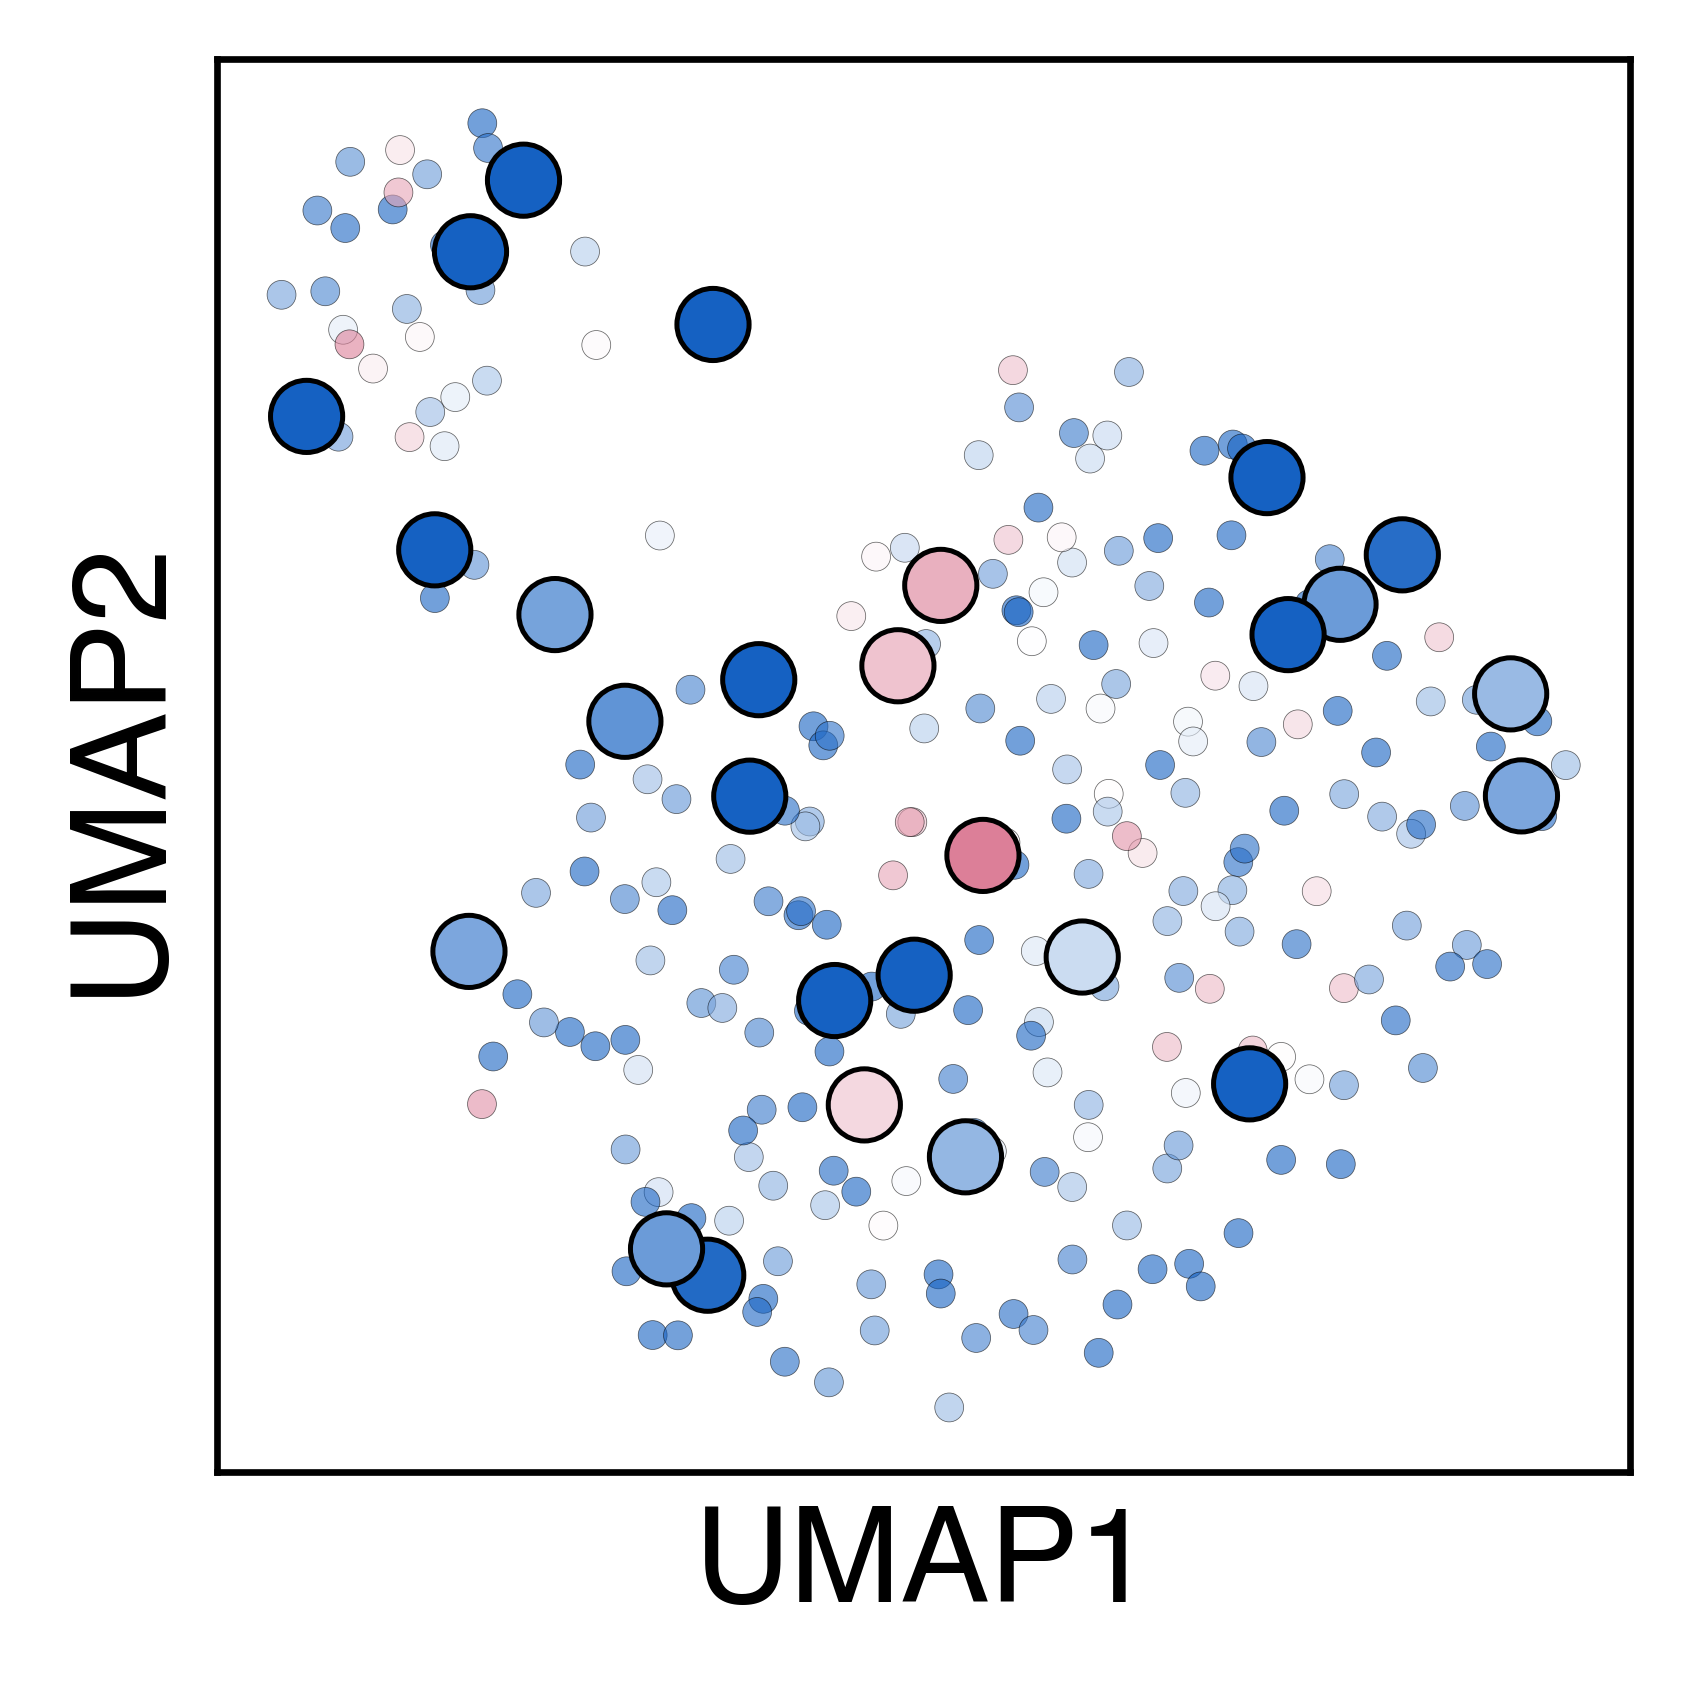

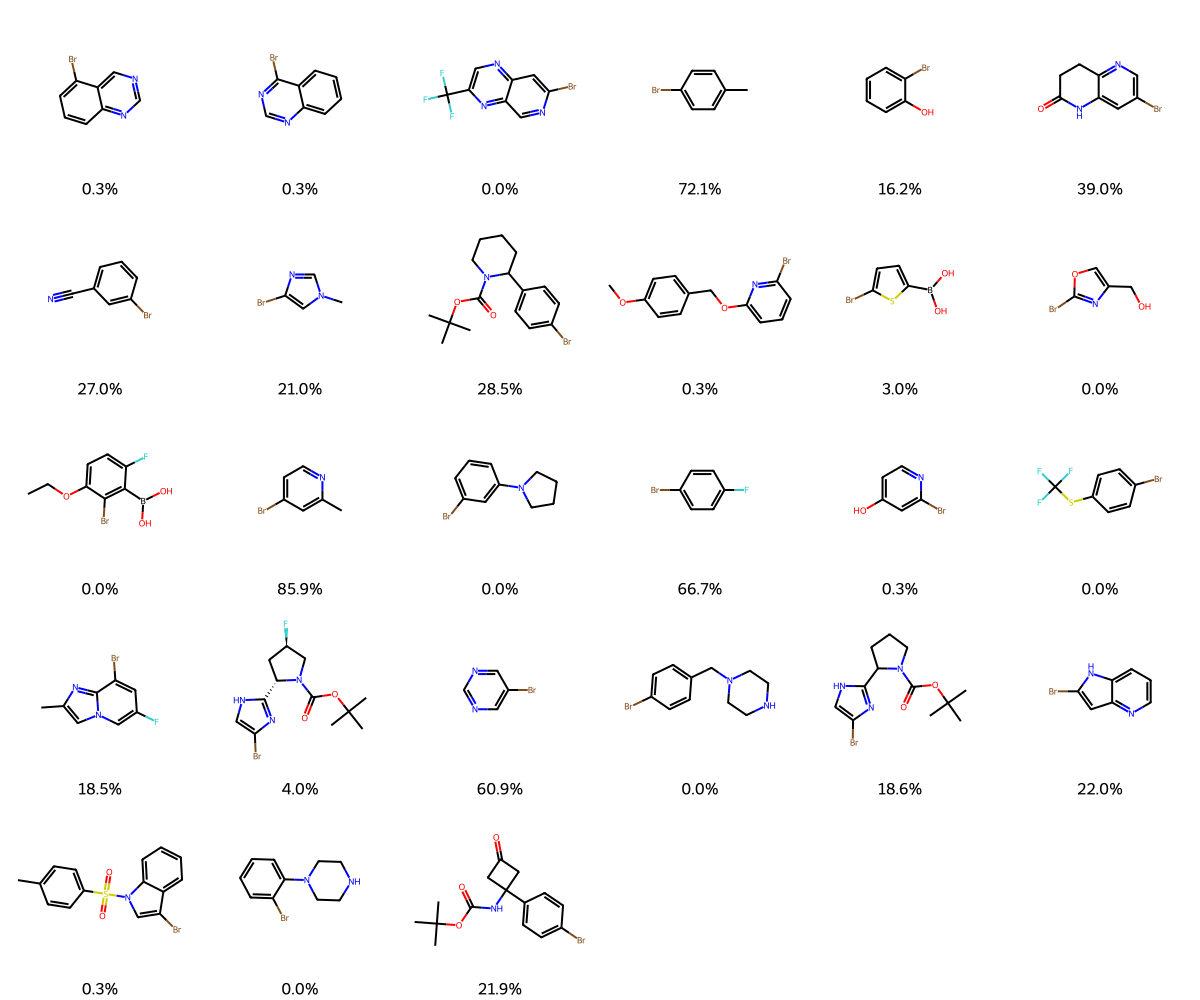

UMAP for Regular BO (EI):

Depicted seed: 6
Scope score: 0.065
Average yield: 19.059
Vendi score: 2.761


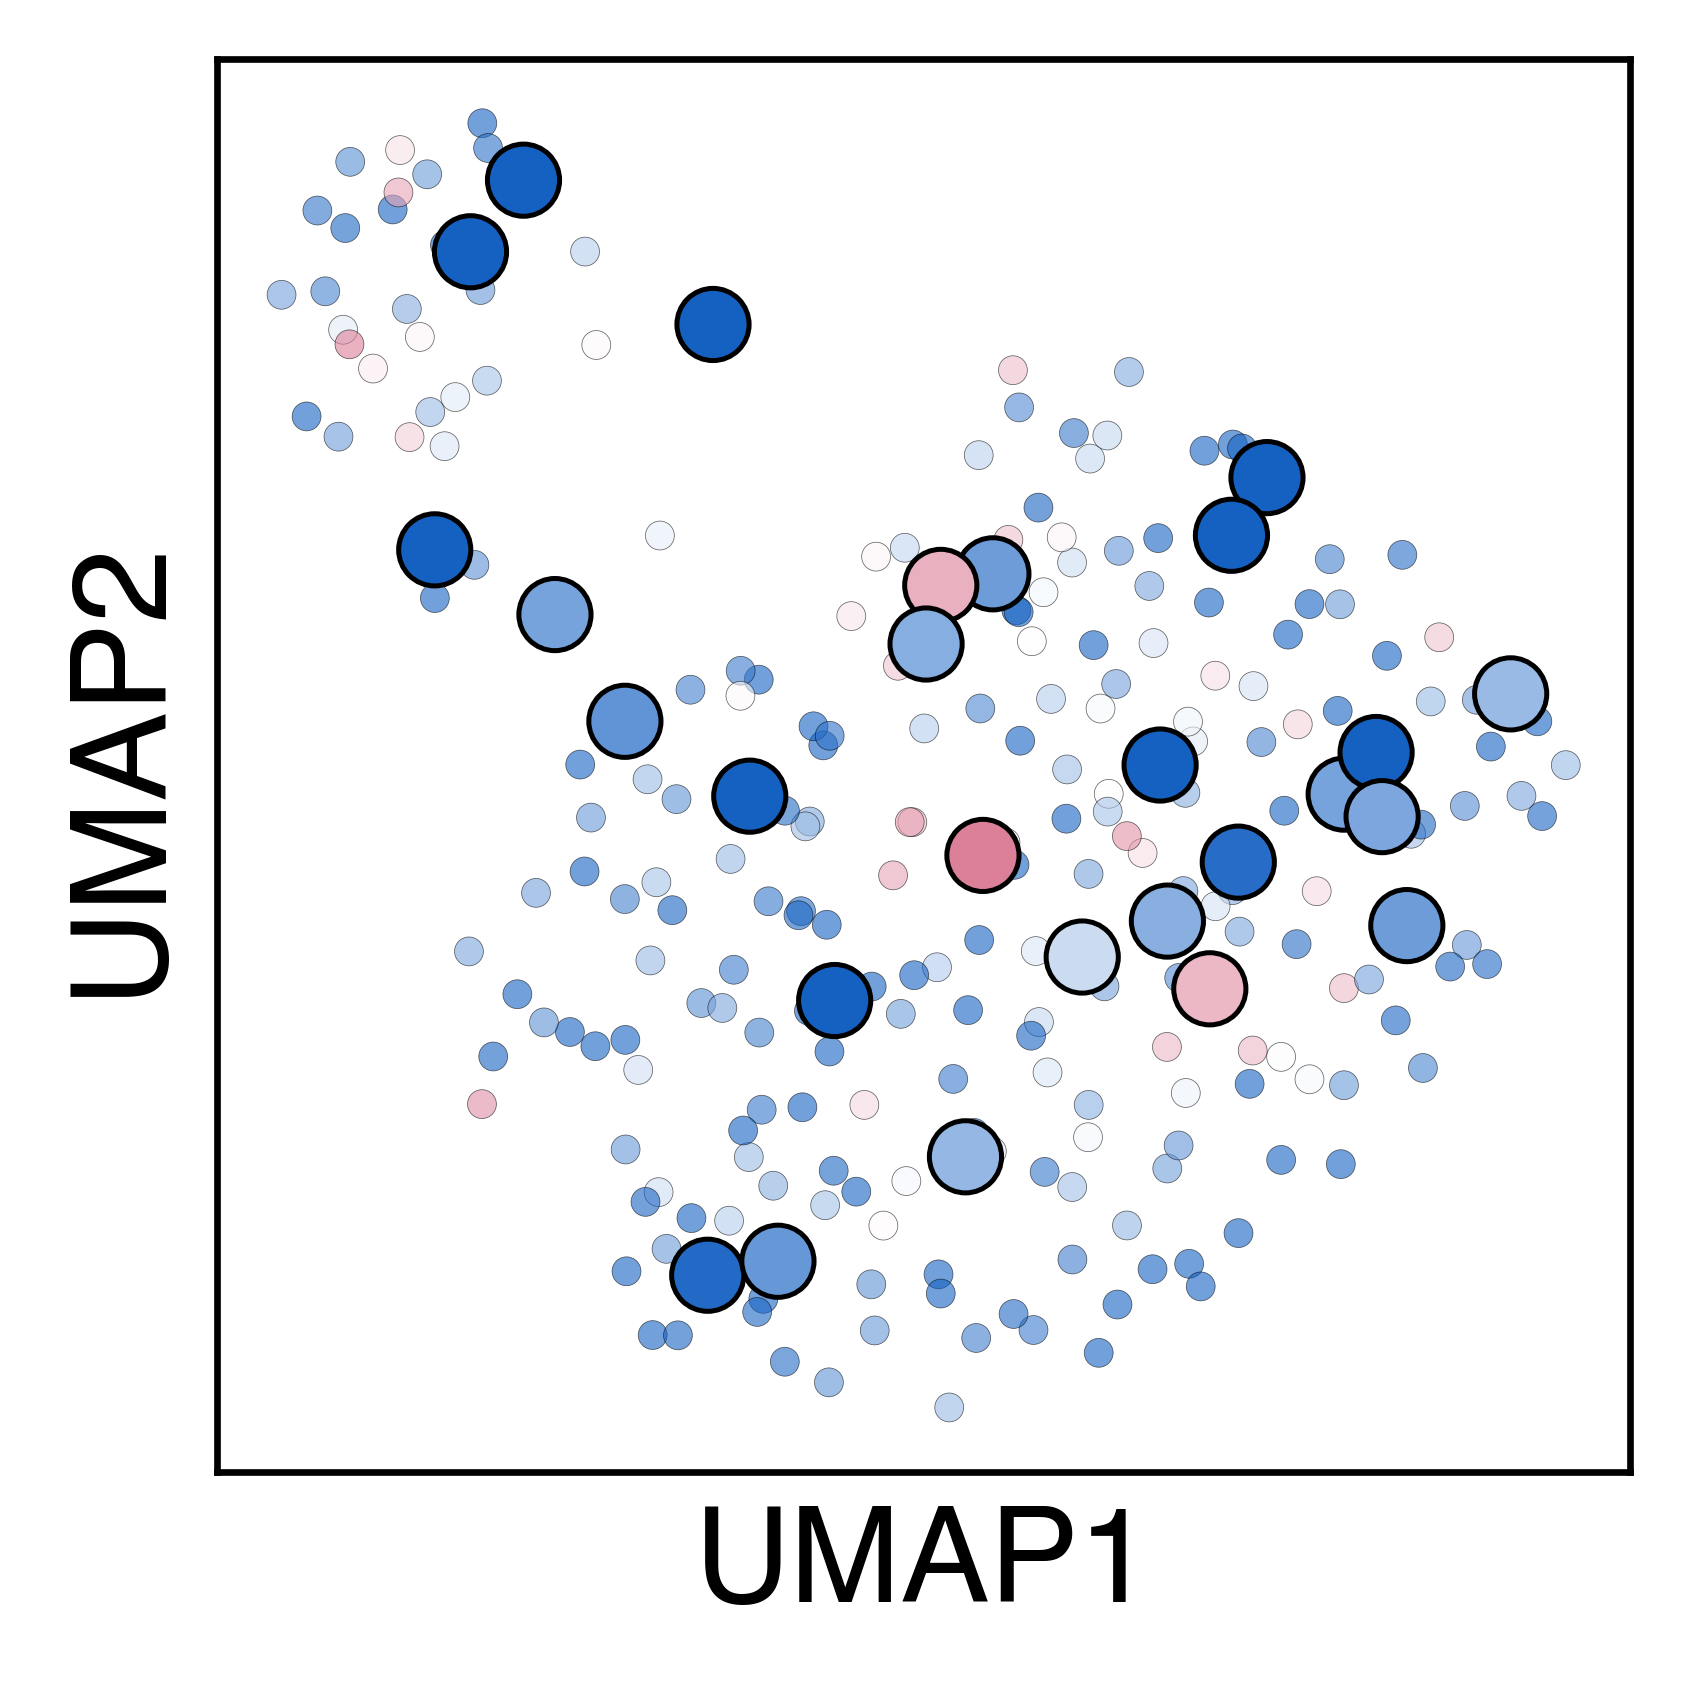

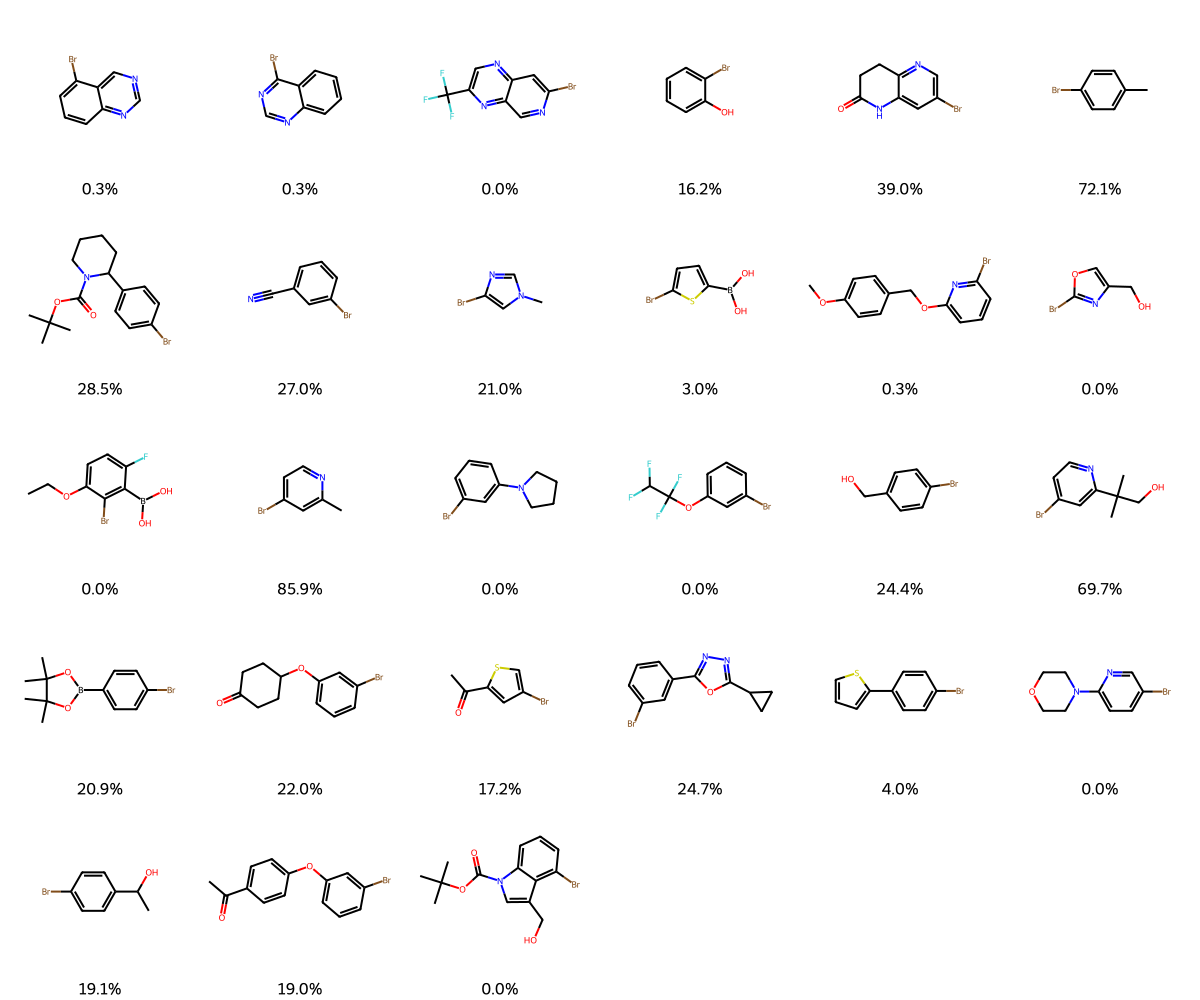

UMAP for conventional selection:

Depicted seed: 6
Scope score: -0.014
Average yield: 35.341
Vendi score: 1.909


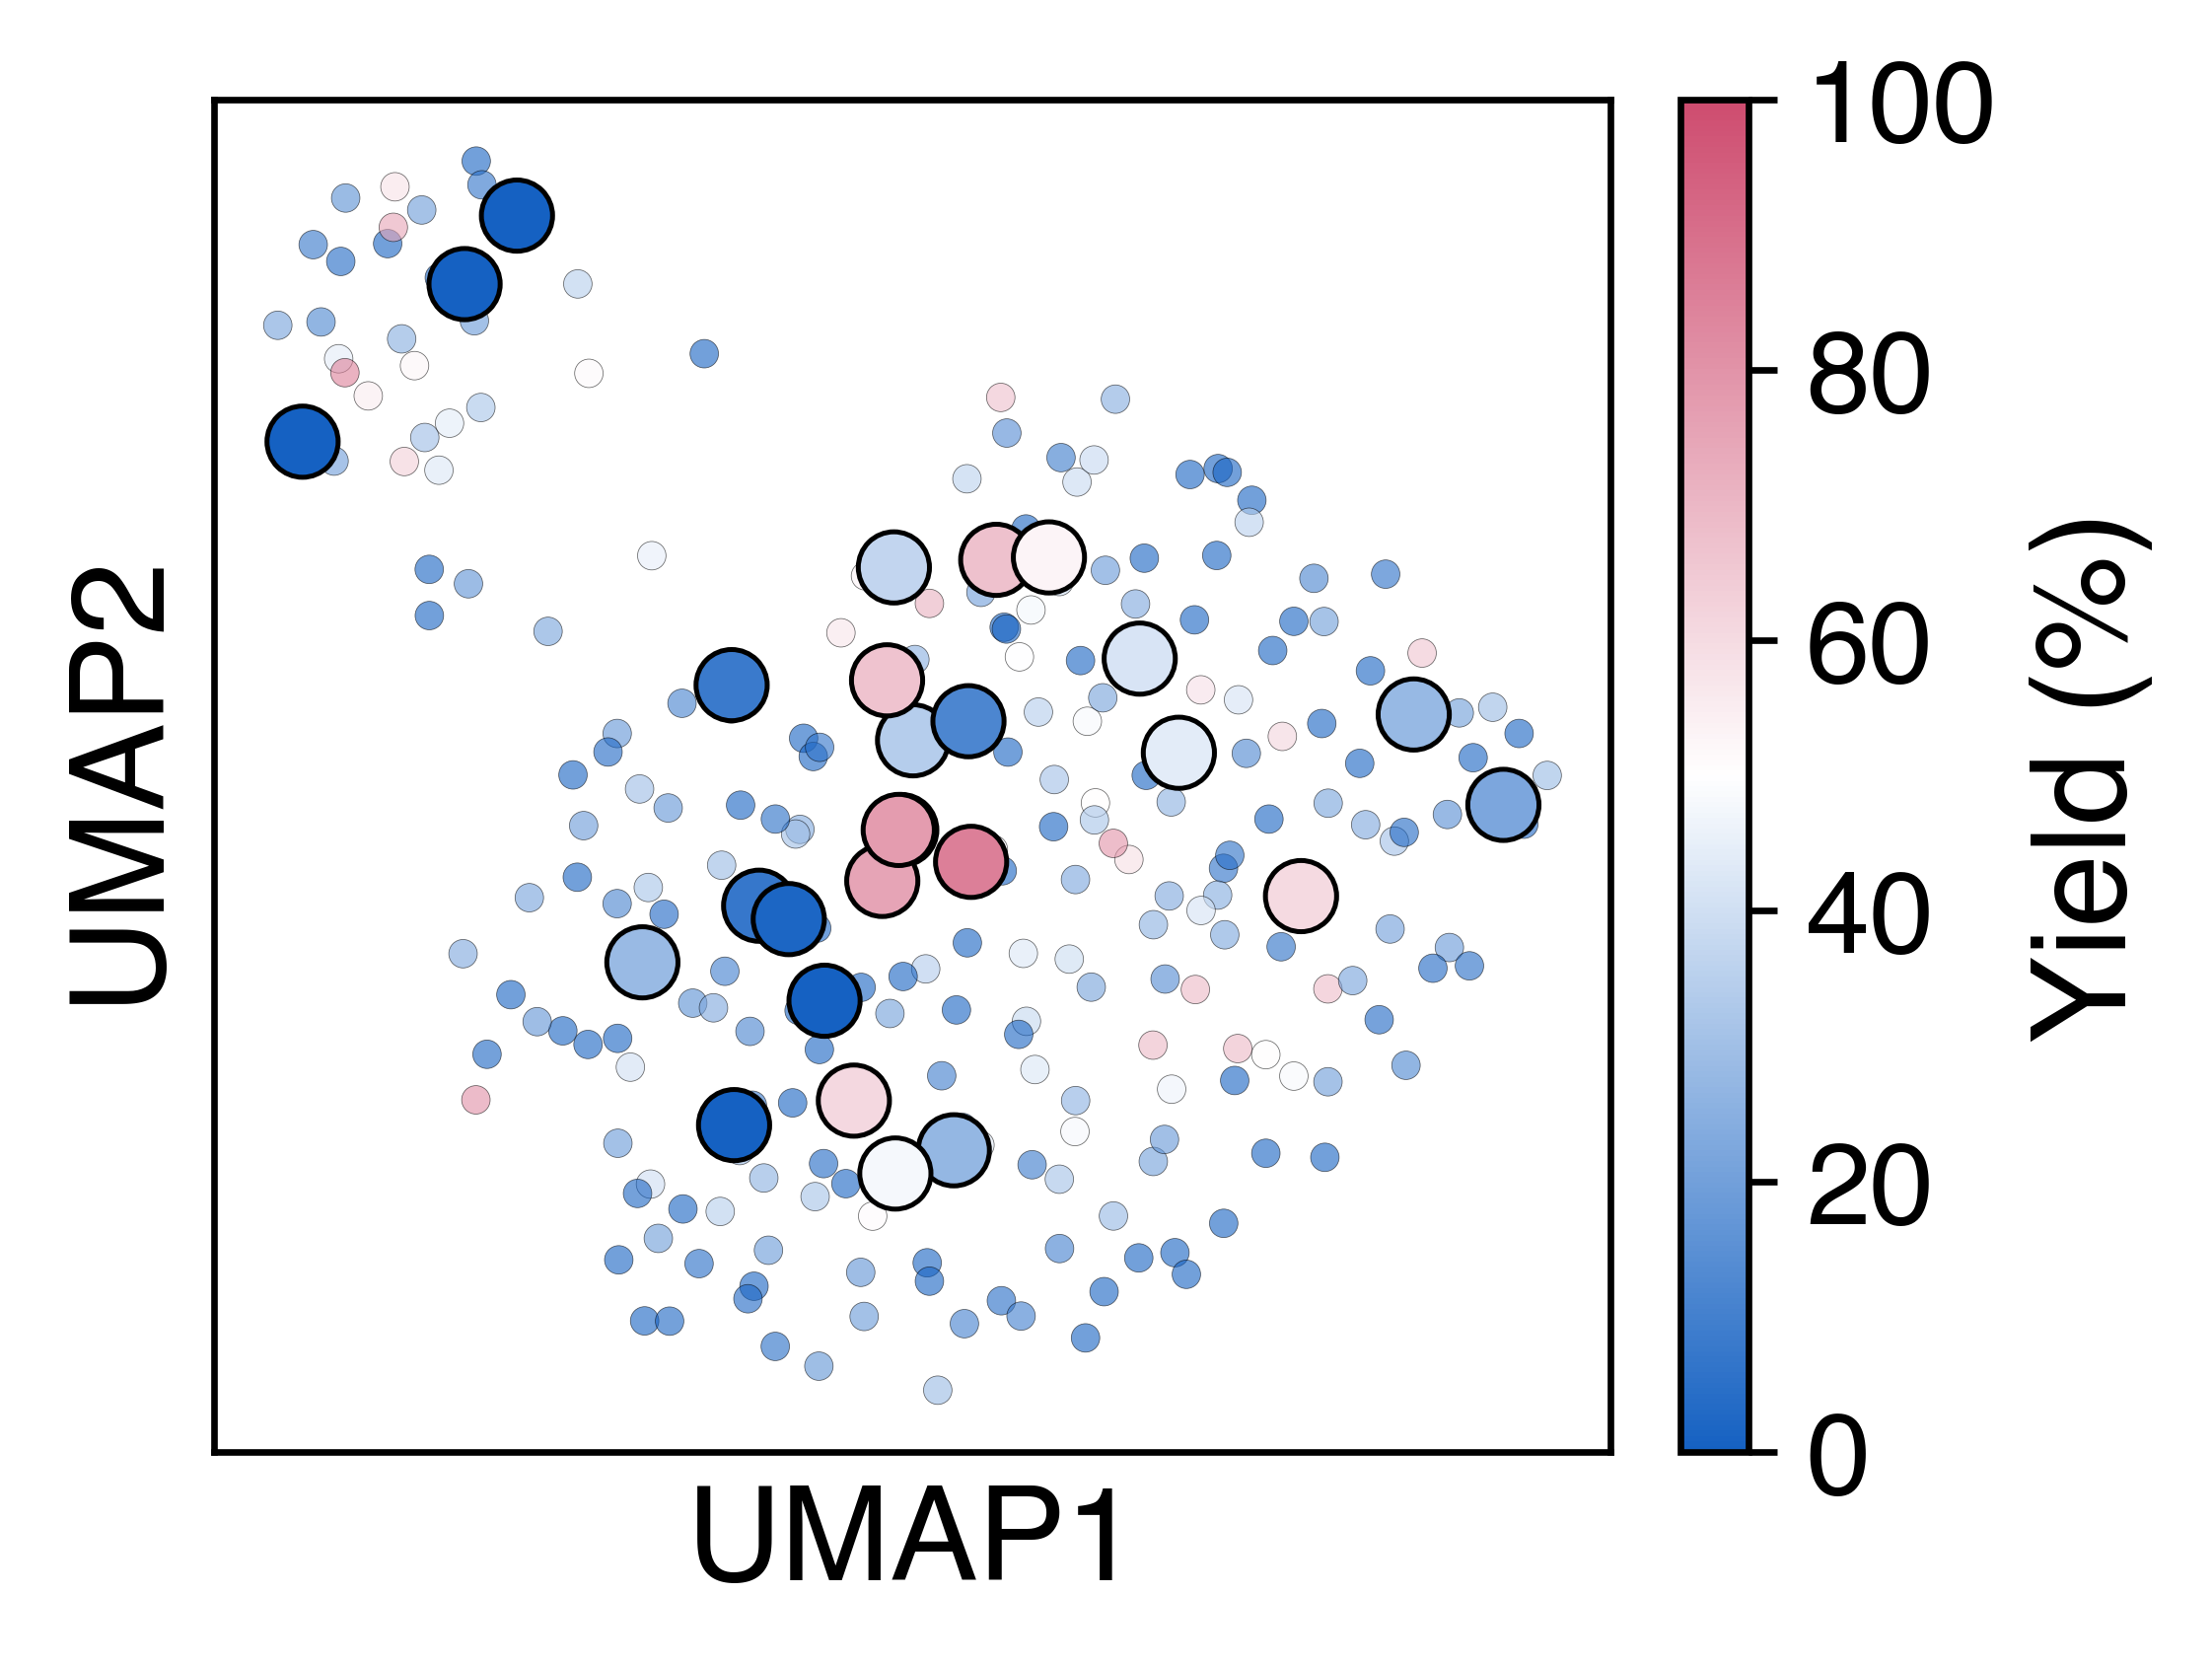

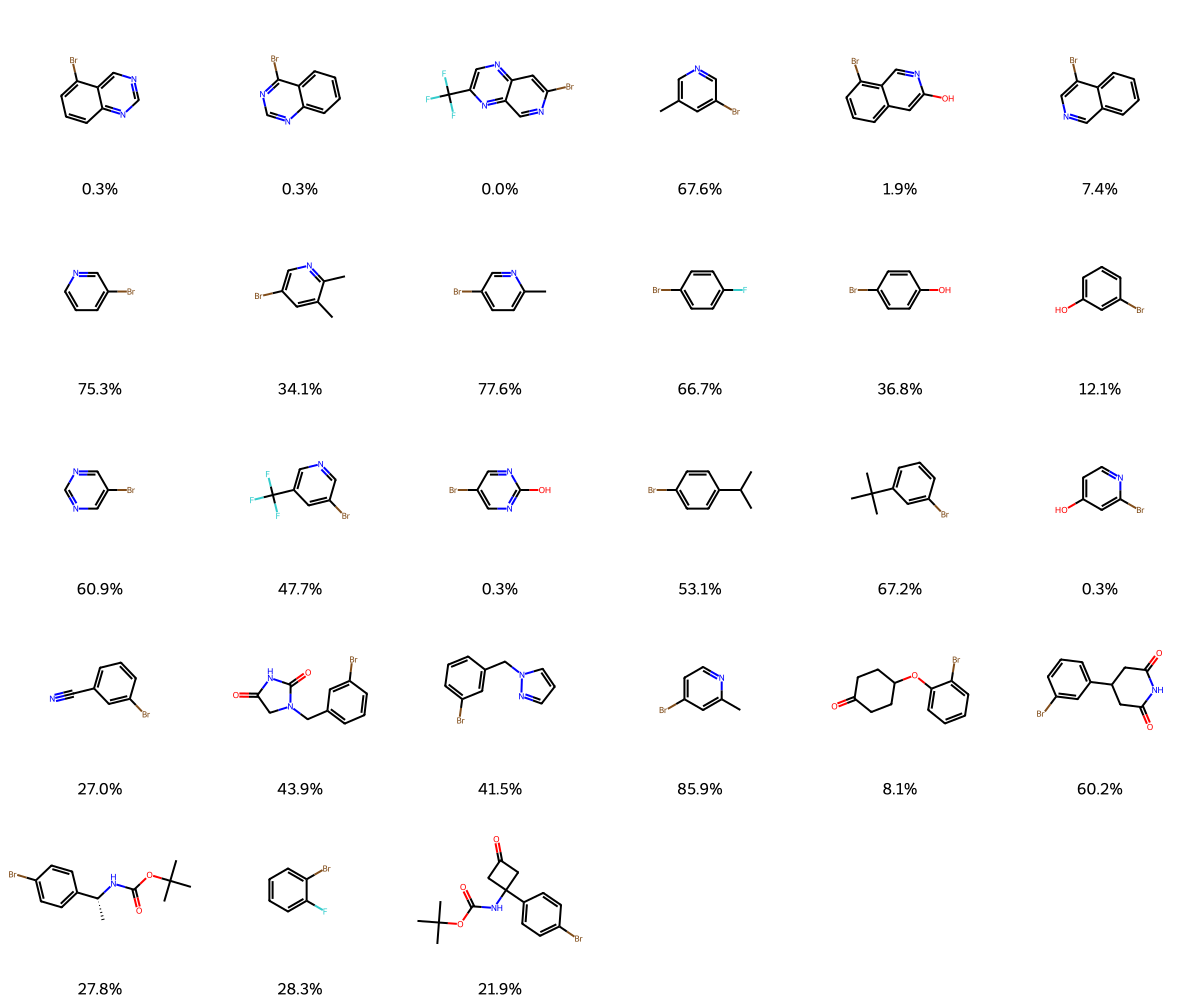

In [50]:
print(f"UMAP for ScopeBO:\n")
seed = get_umap(name_results=f"./Results_Data/results_pruned/scope_ei_with-pruning", bounds=bounds, show_colorbar = False, figsize = (2.7, 2.7))
Benchmark().show_scope(filename_data=f"27balanced_b3_V13_s{seed}.csv", name_results=f"./Results_Data/results_pruned/scope_ei_with-pruning/raw_data", by_round=False,
                        round_values=3, label_suffix="%")
print(f"UMAP for Regular BO (EI):\n")
get_umap(name_results=f"./Results_Data/results_pruned/scope_ei_no-pruning", bounds = bounds, hyperpar="balanced_b3_V0", seed=seed, figsize = (2.7, 2.7))
Benchmark().show_scope(filename_data=f"27balanced_b3_V0_s{seed}.csv", name_results=f"./Results_Data/results_pruned/scope_ei_no-pruning/raw_data", by_round=False,
                        round_values=3, label_suffix="%")
print(f"UMAP for conventional selection:\n")
get_umap(name_results=f"./Results_Data/results_pruned/scope_human-like-acq", hyperpar="greedy_b3_V5", seed = seed, bounds = bounds, figsize = (3.63, 2.7), show_colorbar=True)
Benchmark().show_scope(filename_data=f"27greedy_b3_V5_s{seed}.csv", name_results=f"./Results_Data/results_pruned/scope_human-like-acq/raw_data", by_round=False,
                        round_values=3, label_suffix="%")